# Course Project: West Nile Virus modeling

TEAM: Catherine Duong (data wrangling, features engineering, modeling and optimization), Katrina Armstrong (EDA + DATA VISUALIZATION)


### __Introduction__

West Nile virus (WNV) is the leading cause of mosquito-borne illness in the United States. Between 1999 and 2019, over 7 million human cases were reported with over 50,000 severe cases of West Nile fever and 2400 fatalities. Forecasting when and where WNV outbreaks might occur is an essential task for mosquito control programs.

To monitor for infections, mosquito control program maintain and monitor many different mosquito traps in their district. For instance, the city of Chicago maintains several hundred traps all over the city. Each day workers test these traps by counting the number of mosquitos and testing if any mosquitos are WNV positive. Finding a large number of traps with WNV positive mosquitos means that the local population is at severe risk of WNV infection.

### __Background__

Waiting for traps to test positive means that it will be too late to take preventative action. Instead, Mosquito control programs use statistical methods to forecast if an outbreak of WNV is likely in the next several days. These models use historical outbreak information, spatial information, climate variables, and demographic data to help predict when and where WNV is likely to occur. 


### __Task__

Our task is to build a forecasting model to predict the prevelance of WNV across Chicago one, two, and three weeks in advance

We will model the average _minimum infection rate_ (MIR) each week at each trap location. The MIR is defined as

$$
\text{MIR} = 1000 \times \frac{\text{# positive traps}}{\text{# mosquitos tested}}
$$

For example, if we tested a trap 5 times during the week and saw 10 mosquitos each time and 3 times the trap was positive then $\text{MIR} = 1000 (3/50) = 60$.

You need to build a regression model(s) to predict $\text{MIR}_t, \text{MIR}_{t+1}, \text{MIR}_{t+2}$ based historical information and other covariate information. 
 - You can make one model that predicts all three
 - Or three models that predict each one independently


_note: you will have to create the MIR variable yourself_


### __Data__

There are two provided datasets.

__Mosquito dataset__: `wnv_tests.csv` - All mosquito testing information. Includes dates, times, locations of traps as well as how many mosquitos were tested and whether the trap was positive or not. Data spans 2017-2023. 

__Weather dataset__: `station_data.csv`- Contains metereological information taken from three different sensors at the shore of lake Michigan. Data span 2016-2023 and is collected hourly.


### __Rules__

You may 
1. Use any and all resources you can get your hands on
2. Work in a team of up to 3 people. Please submit your final project as a group and indicate what each team member contributed. 
3. You can ask other teams for help. However, there will be bonus points for the teams with the best models.


### __Evaluation__

This project is meant to be open ended and for you to experience building a machine learning model to solve an actual real world problem. There is no hard grading rubric that can be established since you will all produce very different reports. What I'm looking for is for you build a relatively accurate model, justify it over other approaches with empirical evidence, and to explain your findings with graphs and plain language explanations.

Below I provide "tasks" that are meant to help guide you through this process, but you should feel free to deviate. You should imagine that I work for a mosquito control program and you want to convince me to use your model. I have provided template sections for you to fill out to help ensure you cover all bases.

Points to consider
1. Your plots should be clear, well labeled, and convey a message. Each plot should be succinctly explained with a plain language summary.
2. Your empirical results (test loss, etc.) need to be well organized and clearly displayed. You should provide an explanation of what the results mean.
3. You need to explain what modeling choices you made and why you chose the features that you did. You need to explain why your model works and why the features you chose are necessary.
4. Any decisions you make regarding modeling or data processing need to be documented. I should theoretically be able to recreate your analysis without reading a single line of code.

# Part 1. Exploratory Data Analysis

First things first, we want to visualize the data. Before we model anything we need to know what it "looks like". 

Create the following plots to help you (or someone reading your report) understand what kind of data were dealing with here

1. A map of all mosquito trap locations overlaid on a map of chicago. We would like to know where our data is coming from afterall. Are there any areas that are under or over represented in the dataset? How might this influence our predictions?
2. The weekly MIR averaged across all traps plotted over time. Is there any definite pattern to the data? Could this pattern be useful for predicting trap positivity?
3. The weekly weather variables (all of them) plotted over time. Is there any definite pattern to the data? Do these variables appear to co-vary with the weekly average MIR? 

Some caveats
1. Some of the data have missing values. Up to you how you want to handle them, just tell me what you did.
2. The weather data starts in 2016, but the mosquito data starts in 2017. You will likely need to truncate the weather data and align / merge these two datasets.
3. The weather data has three different stations in it. You can use just one or all of them. Up to you, just tell me what you did.

In [118]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

import IPython.display

# edit this line to point to wherever you downloaded this file and the data
%cd /content/drive/MyDrive/CSCE_421_FINAL_PROJECT/Data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CSCE_421_FINAL_PROJECT/Data


In [119]:
# mosquito and WNV data
# source: https://data.cityofchicago.org/widgets/jqe8-8r6s
wnv = pd.read_csv('wnv_tests.csv')
# weather data
# source: https://data.cityofchicago.org/Parks-Recreation/Beach-Weather-Stations-Automated-Sensors/k7hf-8y75
weather = pd.read_csv('station_data.csv')

### 1.1 Data Cleaning for WNV dataset

In [120]:
# process data
wnv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33898 entries, 0 to 33897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SEASON YEAR           33898 non-null  int64  
 1   WEEK                  33898 non-null  int64  
 2   TEST ID               33898 non-null  int64  
 3   BLOCK                 33898 non-null  object 
 4   TRAP                  33898 non-null  object 
 5   TRAP_TYPE             33898 non-null  object 
 6   TEST DATE             33898 non-null  object 
 7   NUMBER OF MOSQUITOES  33898 non-null  int64  
 8   RESULT                33898 non-null  object 
 9   SPECIES               33898 non-null  object 
 10  LATITUDE              28913 non-null  float64
 11  LONGITUDE             28913 non-null  float64
 12  LOCATION              28913 non-null  object 
dtypes: float64(2), int64(4), object(7)
memory usage: 3.4+ MB


In [121]:
wnv.head()

SEASON YEAR  WEEK  TEST ID                  BLOCK  TRAP TRAP_TYPE  \
0         2017    23    44479  100XX W OHARE AIRPORT  T900    GRAVID   
1         2017    23    44492  100XX W OHARE AIRPORT  T918    GRAVID   
2         2017    23    44491  100XX W OHARE AIRPORT  T913    GRAVID   
3         2017    23    44488  100XX W OHARE AIRPORT  T913    GRAVID   
4         2017    23    44481  100XX W OHARE AIRPORT  T902    GRAVID   

                TEST DATE  NUMBER OF MOSQUITOES    RESULT  \
0  06/16/2017 12:06:00 AM                    30  negative   
1  06/16/2017 12:06:00 AM                     8  negative   
2  06/16/2017 12:06:00 AM                    28  negative   
3  06/16/2017 12:06:00 AM                    35  negative   
4  06/16/2017 12:06:00 AM                    26  negative   

                  SPECIES  LATITUDE  LONGITUDE LOCATION  
0          CULEX RESTUANS       NaN        NaN      NaN  
1  CULEX PIPIENS/RESTUANS       NaN        NaN      NaN  
2          CULEX RESTUANS       NaN        NaN      NaN  
3  CULEX PIPIENS/RESTUANS       NaN        NaN      NaN  
4          CULEX RESTUANS       NaN        NaN      NaN

In [122]:
##show NaN values by column:
wnv.isna().sum()

SEASON YEAR                0
WEEK                       0
TEST ID                    0
BLOCK                      0
TRAP                       0
TRAP_TYPE                  0
TEST DATE                  0
NUMBER OF MOSQUITOES       0
RESULT                     0
SPECIES                    0
LATITUDE                4985
LONGITUDE               4985
LOCATION                4985
dtype: int64

In [123]:
##all NaN values are related to location. It should be ok if we drop all NaN values then:
wnv = wnv.dropna()
##drop duplicate values:
wnv = wnv.drop_duplicates()

In [124]:
##Convert date to datetime from wnv and weather data
wnv['TEST DATE'] = pd.to_datetime(wnv['TEST DATE'])

In [125]:
##checking to see if we need to turn the object values to numerical:
wnv['BLOCK'].unique()
## um that one is probably fine

array(['17XX W ADDISON ST', '5XX S CENTRAL AVE', '58XX N WESTERN AVE',
       '11XX S CALIFORNIA AVE', '51XX N MONT CLARE AVE',
       '62XX N MCCLELLAN AVE', '67XX S KEDZIE AVE', '22XX N CANNON DR',
       '41XX N OAK PARK AVE', '52XX W 63RD ST', '35XX W 51ST ST',
       '82XX S KOSTNER AVE', '22XX W 51ST ST', '14XX N HUMBOLDT DR',
       '10XX E 67TH ST', '11XX W ROOSEVELT RD', '61XX W FULLERTON AVE',
       '127XX S DOTY AVE', '61XX N LEMONT AVE', '17XX N PULASKI RD',
       '50XX S UNION AVE', '131XX S BRANDON AVE', '3XX W 104TH ST',
       '71XX S SOUTH SHORE DR', '28XX N FRANCISCO AVE',
       '37XX S PULASKI RD', '91XX W HIGGINS RD', '42XX W 65TH ST',
       '22XX W 69TH ST', '45XX N CAMPBELL AVE', '55XX S NARRAGANSETT AVE',
       '9XX W GARFIELD BLVD', '48XX W MONTANA ST', '13XX N LARAMIE AVE',
       '12XX W GREENLEAF AVE', '1XX N CENTRAL PARK DR',
       '70XX W ARMITAGE AVE', '25XX W GRAND AVE', '20XX N DOMINICK ST',
       '119XX S ASHLAND AVE', '104XX S VINCENNES AVE',
  

In [126]:
wnv['TRAP'].unique()
## that one too -> identifiers?

array(['T224', 'T031', 'T028', 'T047', 'T223', 'T236', 'T066', 'T054A',
       'T002', 'T065', 'T062', 'T225', 'T061', 'T054B', 'T033', 'T073',
       'T048', 'T013', 'T115', 'T012', 'T039', 'T082', 'T209', 'T095',
       'T079', 'T147', 'T063', 'T009', 'T235', 'T069', 'T220', 'T242',
       'T226', 'T222', 'T230', 'T018', 'T030B', 'T151', 'T046', 'T240',
       'T090', 'T089', 'T008', 'T030', 'T221', 'T231', 'T128', 'T102',
       'T212', 'T159', 'T011', 'T138', 'T054C', 'T094', 'T080', 'T017',
       'T035', 'T049', 'T074', 'T233', 'T227', 'T003', 'T027', 'T114',
       'T155', 'T228', 'T152', 'T099', 'T046B', 'T077', 'T087', 'T158',
       'T160', 'T027B', 'T076', 'T092', 'T240B', 'T028B', 'T232', 'T107',
       'T088', 'T148', 'T045', 'T084', 'T215', 'T153', 'T067', 'T043',
       'T200', 'T162', 'T218', 'T144', 'T065A', 'T091', 'T081', 'T014',
       'T002B', 'T200A', 'T051', 'T200B', 'T060', 'T016', '220A', 'T015',
       'T161', 'T229', 'T096', 'T050', 'T203', 'T044', 'T146', 'T

In [127]:
##easily convert to numeric: we will make negative 0 and positive 1
wnv["RESULT"] = wnv["RESULT"].replace('negative', 0)
wnv["RESULT"] = wnv["RESULT"].replace('positive', 1)

In [128]:
wnv['SPECIES'].unique()
##probably ok to leave this one as an object

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX TERRITANS',
       'CULEX SALINARIUS', 'CULEX PIPIENS', 'CULEX TARSALIS',
       'CULEX ERRATICUS', 'UNSPECIFIED CULEX'], dtype=object)

In [129]:
wnv['LOCATION'].unique()

array(['(41.94704449504484, -87.67306105349785)',
       '(41.87287286249572, -87.7647365320396)',
       '(41.98724460846669, -87.68941677018957)',
       '(41.86759925367238, -87.69578544257037)',
       '(41.974522761157274, -87.80458946950488)',
       '(41.99496630402897, -87.77083721987879)',
       '(41.77119858797388, -87.70310660774493)',
       '(41.92273664946568, -87.63244996720142)',
       '(41.956298856118664, -87.79751744482932)',
       '(41.77830515554422, -87.75436628603191)',
       '(41.8005970872007, -87.7117303452467)',
       '(41.7426704781299, -87.73155005887604)',
       '(41.80104785720396, -87.68042473369341)',
       '(41.92206380002785, -87.63223305992274)',
       '(41.90728487283588, -87.701394636759)',
       '(41.773085401492715, -87.60016755939222)',
       '(41.86691518161014, -87.65491884363057)',
       '(41.92388736426867, -87.77890991205359)',
       '(41.66238672759086, -87.59017972751752)',
       '(41.99356436155678, -87.74542038704298)',
   

### 1.2 Data cleaning for weather dataset

In [130]:
##number of na values
weather.isna().sum().sum()

267626

In [131]:
weather["Station Name"].nunique()

3

In [132]:
weather.head()

Station Name   Measurement Timestamp  Air Temperature  \
0  63rd Street Weather Station  09/27/2018 10:00:00 AM            16.40   
1  63rd Street Weather Station  09/27/2018 11:00:00 AM            17.10   
2  63rd Street Weather Station  09/27/2018 01:00:00 PM            18.20   
3       Foster Weather Station  09/27/2018 01:00:00 PM            17.89   
4  63rd Street Weather Station  09/27/2018 03:00:00 PM            19.50   

   Wet Bulb Temperature  Humidity  Rain Intensity  Interval Rain  Total Rain  \
0                  12.2        61             0.0            0.0       260.3   
1                  11.5        51             0.0            0.0       260.3   
2                  12.4        51             0.0            0.0       260.3   
3                   NaN        39             NaN            0.0         NaN   
4                  13.0        47             0.0            0.0       260.3   

   Precipitation Type  Wind Direction  Wind Speed  Maximum Wind Speed  \
0                 0.0             231         2.5                 4.7   
1                 0.0             244         3.6                 5.7   
2                 0.0             248         3.1                 5.3   
3                 NaN             249         1.4                 2.3   
4                 0.0             249         3.1                 5.7   

   Barometric Pressure  Solar Radiation  Heading  Battery Life  \
0                996.3              484    356.0          11.9   
1                995.4              468    356.0          11.9   
2                994.8              377    355.0          11.9   
3                993.6                0      NaN          15.1   
4                992.9              461    355.0          11.9   

  Measurement Timestamp Label                        Measurement ID  
0         09/27/2018 10:00 AM  63rdStreetWeatherStation201809271000  
1         09/27/2018 11:00 AM  63rdStreetWeatherStation201809271100  
2          09/27/2018 1:00 PM  63rdStreetWeatherStation201809271300  
3          09/27/2018 1:00 PM      FosterWeatherStation201809271300  
4          09/27/2018 3:00 PM  63rdStreetWeatherStation201809271500

In [133]:
##check by column
weather.isna().sum()

Station Name                       0
Measurement Timestamp              0
Air Temperature                   75
Wet Bulb Temperature           53481
Humidity                           0
Rain Intensity                 53481
Interval Rain                      0
Total Rain                     53481
Precipitation Type             53481
Wind Direction                     0
Wind Speed                         0
Maximum Wind Speed                 0
Barometric Pressure              146
Solar Radiation                    0
Heading                        53481
Battery Life                       0
Measurement Timestamp Label        0
Measurement ID                     0
dtype: int64

In [134]:

weather = weather.drop(['Wet Bulb Temperature'], axis = 1)
weather = weather.drop(['Rain Intensity'], axis = 1)
weather = weather.drop(['Total Rain'], axis =1)
weather = weather.drop(['Precipitation Type'], axis =1)
#weather['Total Rain'] = weather['Total Rain'].fillna((weather['Total Rain'].mean()))
#weather['Precipitation Type'] = weather['Precipitation Type'].fillna((weather['Precipitation Type'].mean()))
weather = weather.drop(['Heading'], axis = 1)


In [135]:
'''
weather['Total Rain'] = weather['Total Rain'].fillna((weather['Total Rain'].mean()))
weather['Precipitation Type'] = weather['Precipitation Type'].fillna((weather['Precipitation Type'].mean()))
weather['Rain Intensity'] = weather['Rain Intensity'].fillna((weather['Rain Intensity'].mean()))
weather['Wet Bulb Temperature'] = weather['Wet Bulb Temperature'].fillna((weather['Wet Bulb Temperature'].mean()))
weather = weather.drop(['Heading'], axis = 1)
'''

"\nweather['Total Rain'] = weather['Total Rain'].fillna((weather['Total Rain'].mean()))\nweather['Precipitation Type'] = weather['Precipitation Type'].fillna((weather['Precipitation Type'].mean()))\nweather['Rain Intensity'] = weather['Rain Intensity'].fillna((weather['Rain Intensity'].mean()))\nweather['Wet Bulb Temperature'] = weather['Wet Bulb Temperature'].fillna((weather['Wet Bulb Temperature'].mean()))\nweather = weather.drop(['Heading'], axis = 1)\n"

In [136]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152364 entries, 0 to 152363
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Station Name                 152364 non-null  object 
 1   Measurement Timestamp        152364 non-null  object 
 2   Air Temperature              152289 non-null  float64
 3   Humidity                     152364 non-null  int64  
 4   Interval Rain                152364 non-null  float64
 5   Wind Direction               152364 non-null  int64  
 6   Wind Speed                   152364 non-null  float64
 7   Maximum Wind Speed           152364 non-null  float64
 8   Barometric Pressure          152218 non-null  float64
 9   Solar Radiation              152364 non-null  int64  
 10  Battery Life                 152364 non-null  float64
 11  Measurement Timestamp Label  152364 non-null  object 
 12  Measurement ID               152364 non-null  object 
dtyp

In [137]:
weather = weather.drop_duplicates()


### 1.3 Data summary
Briefly introduce and describe the two data sets. What years are covered? What location? How many observations? What kinds of features are available?


In [138]:
wnv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28913 entries, 20 to 33897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   SEASON YEAR           28913 non-null  int64         
 1   WEEK                  28913 non-null  int64         
 2   TEST ID               28913 non-null  int64         
 3   BLOCK                 28913 non-null  object        
 4   TRAP                  28913 non-null  object        
 5   TRAP_TYPE             28913 non-null  object        
 6   TEST DATE             28913 non-null  datetime64[ns]
 7   NUMBER OF MOSQUITOES  28913 non-null  int64         
 8   RESULT                28913 non-null  int64         
 9   SPECIES               28913 non-null  object        
 10  LATITUDE              28913 non-null  float64       
 11  LONGITUDE             28913 non-null  float64       
 12  LOCATION              28913 non-null  object        
dtypes: datetime64[n

In [139]:
wnv['SEASON YEAR'].unique()

array([2021, 2022, 2020, 2019, 2007, 2009, 2016, 2008, 2012, 2018, 2013,
       2017, 2015, 2011, 2014, 2010])

In [140]:
wnv['WEEK'].unique()

array([23, 24, 35, 25, 26, 36, 33, 27, 28, 31, 30, 38, 37, 39, 32, 34, 29,
       40, 22, 20, 21])

In [141]:
##the data is from 2007-2022
##and we know that the location is all in chicago (from map)
##there are 33,898 entries in the data set
##and there are 13 features

### 1.4 Data processing
Briefly describe how the data was processed. Did you drop NA? Did you exclude any observations? Describe what you did so someone who doesnt have your code could follow along.


### 1.5 Calculating the MRI 

In [142]:
# Make the MIR column in the wnv dataset
# group by week and season year + trap_id -> calculate sum(result==1)/sum(number of mosquitos)
res_2 = wnv.groupby(by=['TRAP','SEASON YEAR','WEEK','TEST DATE','BLOCK','LONGITUDE','LATITUDE',wnv['RESULT']==1])['NUMBER OF MOSQUITOES'].sum().reset_index()
#Getting ony the positive number of mosquitoes
res_2.rename(columns={'NUMBER OF MOSQUITOES': 'positive_num'},inplace=True)
res_2.loc[res_2['RESULT'] == False, 'positive_num'] = 0 
res_2 = res_2.drop_duplicates(subset=['TRAP','SEASON YEAR','WEEK'], keep='last')

In [143]:
res_2[res_2['TRAP']=='220A']

TRAP  SEASON YEAR  WEEK           TEST DATE              BLOCK  LONGITUDE  \
1  220A         2008    34 2008-08-26 00:08:00  58XX N PULASKI RD -87.728398   
2  220A         2008    35 2008-09-02 00:09:00  58XX N PULASKI RD -87.728398   
3  220A         2008    36 2008-09-09 00:09:00  58XX N PULASKI RD -87.728398   
4  220A         2008    37 2008-09-15 00:09:00  58XX N PULASKI RD -87.728398   
5  220A         2008    38 2008-09-19 00:09:00  58XX N PULASKI RD -87.728398   
6  220A         2008    39 2008-09-29 00:09:00  58XX N PULASKI RD -87.728398   

    LATITUDE  RESULT  positive_num  
1  41.987054    True            50  
2  41.987054   False             0  
3  41.987054    True             7  
4  41.987054   False             0  
5  41.987054   False             0  
6  41.987054   False             0

In [144]:
res = wnv.groupby(by=['TRAP','SEASON YEAR','WEEK','TEST DATE','BLOCK'])['NUMBER OF MOSQUITOES'].sum().reset_index()

In [145]:
#Merge two dataset together
final_df = res.merge(res_2, how='inner',on=['TRAP','SEASON YEAR','WEEK'])
#Calculating the MRI_rate
final_df['MRI_rate']=1000*(final_df['positive_num']/final_df['NUMBER OF MOSQUITOES'])

In [146]:
#View the final result
final_df[final_df['TRAP']=='220A']

TRAP  SEASON YEAR  WEEK         TEST DATE_x            BLOCK_x  \
0  220A         2008    34 2008-08-26 00:08:00  58XX N PULASKI RD   
1  220A         2008    35 2008-09-02 00:09:00  58XX N PULASKI RD   
2  220A         2008    36 2008-09-09 00:09:00  58XX N PULASKI RD   
3  220A         2008    37 2008-09-15 00:09:00  58XX N PULASKI RD   
4  220A         2008    38 2008-09-19 00:09:00  58XX N PULASKI RD   
5  220A         2008    39 2008-09-29 00:09:00  58XX N PULASKI RD   

   NUMBER OF MOSQUITOES         TEST DATE_y            BLOCK_y  LONGITUDE  \
0                    68 2008-08-26 00:08:00  58XX N PULASKI RD -87.728398   
1                    26 2008-09-02 00:09:00  58XX N PULASKI RD -87.728398   
2                     7 2008-09-09 00:09:00  58XX N PULASKI RD -87.728398   
3                    10 2008-09-15 00:09:00  58XX N PULASKI RD -87.728398   
4                     2 2008-09-19 00:09:00  58XX N PULASKI RD -87.728398   
5                     3 2008-09-29 00:09:00  58XX N PULASKI RD -87.728398   

    LATITUDE  RESULT  positive_num     MRI_rate  
0  41.987054    True            50   735.294118  
1  41.987054   False             0     0.000000  
2  41.987054    True             7  1000.000000  
3  41.987054   False             0     0.000000  
4  41.987054   False             0     0.000000  
5  41.987054   False             0     0.000000

In [147]:
# This is for checking the calculations
new = wnv.sort_values(['TRAP','SEASON YEAR','WEEK'])
new[new['TRAP']=='220A']

SEASON YEAR  WEEK  TEST ID              BLOCK  TRAP TRAP_TYPE  \
13006         2008    34    25638  58XX N PULASKI RD  220A    GRAVID   
16156         2008    34    25636  58XX N PULASKI RD  220A    GRAVID   
19038         2008    34    25635  58XX N PULASKI RD  220A    GRAVID   
32570         2008    34    25637  58XX N PULASKI RD  220A    GRAVID   
12892         2008    35    25734  58XX N PULASKI RD  220A    GRAVID   
30585         2008    35    25736  58XX N PULASKI RD  220A    GRAVID   
32519         2008    35    25735  58XX N PULASKI RD  220A    GRAVID   
18098         2008    36    25955  58XX N PULASKI RD  220A    GRAVID   
11013         2008    37    26004  58XX N PULASKI RD  220A    GRAVID   
14455         2008    38    26093  58XX N PULASKI RD  220A    GRAVID   
23032         2008    39    26119  58XX N PULASKI RD  220A    GRAVID   

                TEST DATE  NUMBER OF MOSQUITOES  RESULT  \
13006 2008-08-26 00:08:00                     6       0   
16156 2008-08-26 00:08:00                    50       1   
19038 2008-08-26 00:08:00                     5       0   
32570 2008-08-26 00:08:00                     7       0   
12892 2008-09-02 00:09:00                     1       0   
30585 2008-09-02 00:09:00                     5       0   
32519 2008-09-02 00:09:00                    20       0   
18098 2008-09-09 00:09:00                     7       1   
11013 2008-09-15 00:09:00                    10       0   
14455 2008-09-19 00:09:00                     2       0   
23032 2008-09-29 00:09:00                     3       0   

                      SPECIES   LATITUDE  LONGITUDE  \
13006          CULEX RESTUANS  41.987054 -87.728398   
16156  CULEX PIPIENS/RESTUANS  41.987054 -87.728398   
19038           CULEX PIPIENS  41.987054 -87.728398   
32570  CULEX PIPIENS/RESTUANS  41.987054 -87.728398   
12892           CULEX PIPIENS  41.987054 -87.728398   
30585          CULEX RESTUANS  41.987054 -87.728398   
32519  CULEX PIPIENS/RESTUANS  41.987054 -87.728398   
18098  CULEX PIPIENS/RESTUANS  41.987054 -87.728398   
11013  CULEX PIPIENS/RESTUANS  41.987054 -87.728398   
14455  CULEX PIPIENS/RESTUANS  41.987054 -87.728398   
23032  CULEX PIPIENS/RESTUANS  41.987054 -87.728398   

                                       LOCATION  
13006  (41.987053811133364, -87.72839753205471)  
16156  (41.987053811133364, -87.72839753205471)  
19038  (41.987053811133364, -87.72839753205471)  
32570  (41.987053811133364, -87.72839753205471)  
12892  (41.987053811133364, -87.72839753205471)  
30585  (41.987053811133364, -87.72839753205471)  
32519  (41.987053811133364, -87.72839753205471)  
18098  (41.987053811133364, -87.72839753205471)  
11013  (41.987053811133364, -87.72839753205471)  
14455  (41.987053811133364, -87.72839753205471)  
23032  (41.987053811133364, -87.72839753205471)

### 1.6 Averaging Weather Conditions by Date/Time

In [148]:
weather.head(5)

Station Name   Measurement Timestamp  Air Temperature  \
0  63rd Street Weather Station  09/27/2018 10:00:00 AM            16.40   
1  63rd Street Weather Station  09/27/2018 11:00:00 AM            17.10   
2  63rd Street Weather Station  09/27/2018 01:00:00 PM            18.20   
3       Foster Weather Station  09/27/2018 01:00:00 PM            17.89   
4  63rd Street Weather Station  09/27/2018 03:00:00 PM            19.50   

   Humidity  Interval Rain  Wind Direction  Wind Speed  Maximum Wind Speed  \
0        61            0.0             231         2.5                 4.7   
1        51            0.0             244         3.6                 5.7   
2        51            0.0             248         3.1                 5.3   
3        39            0.0             249         1.4                 2.3   
4        47            0.0             249         3.1                 5.7   

   Barometric Pressure  Solar Radiation  Battery Life  \
0                996.3              484          11.9   
1                995.4              468          11.9   
2                994.8              377          11.9   
3                993.6                0          15.1   
4                992.9              461          11.9   

  Measurement Timestamp Label                        Measurement ID  
0         09/27/2018 10:00 AM  63rdStreetWeatherStation201809271000  
1         09/27/2018 11:00 AM  63rdStreetWeatherStation201809271100  
2          09/27/2018 1:00 PM  63rdStreetWeatherStation201809271300  
3          09/27/2018 1:00 PM      FosterWeatherStation201809271300  
4          09/27/2018 3:00 PM  63rdStreetWeatherStation201809271500

In [149]:
##need to group by Measurement Timestamp
##first we should drop the non numeric columns besides name and timestamp
weatherE = weather.drop(['Measurement Timestamp Label', 'Measurement ID'], axis = 1)
##then group by station name and measurement timestamp
weatherE['Measurement Timestamp'] = pd.to_datetime(weatherE['Measurement Timestamp'])

In [150]:
weatherE2 = weatherE.sort_values(by = ['Station Name', 'Measurement Timestamp'])
weatherE2.head()
weatherE2.rename(columns = {'Measurement Timestamp':'Timestamp'}, inplace = True)

In [151]:

weatherE2.Timestamp = weatherE2.Timestamp.astype(str)
weatherE2.info()
weatherE2[['Date','Time']] = weatherE2.Timestamp.str.split(expand=True)
weatherE2.drop(['Timestamp', 'Time'], axis = 1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152364 entries, 30916 to 152362
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Station Name         152364 non-null  object 
 1   Timestamp            152364 non-null  object 
 2   Air Temperature      152289 non-null  float64
 3   Humidity             152364 non-null  int64  
 4   Interval Rain        152364 non-null  float64
 5   Wind Direction       152364 non-null  int64  
 6   Wind Speed           152364 non-null  float64
 7   Maximum Wind Speed   152364 non-null  float64
 8   Barometric Pressure  152218 non-null  float64
 9   Solar Radiation      152364 non-null  int64  
 10  Battery Life         152364 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 13.9+ MB


Station Name  Air Temperature  Humidity  Interval Rain  \
30916   63rd Street Weather Station              7.0        86            5.0   
30917   63rd Street Weather Station              6.1        76            0.0   
30918   63rd Street Weather Station             25.4        85            0.0   
30919   63rd Street Weather Station             26.4        81            0.0   
30920   63rd Street Weather Station             25.9        84            0.0   
...                             ...              ...       ...            ...   
152354   Oak Street Weather Station              3.2        69            0.0   
152356   Oak Street Weather Station              3.2        72            0.0   
152358   Oak Street Weather Station              3.4        67            0.0   
152360   Oak Street Weather Station              3.2        70            0.0   
152362   Oak Street Weather Station              3.4        69            0.0   

        Wind Direction  Wind Speed  Maximum Wind Speed  Barometric Pressure  \
30916              119         5.1                 7.1                986.1   
30917               11         7.2                13.0                989.9   
30918              223         2.3                 5.3                989.9   
30919              245         5.6                 8.8                990.9   
30920              217         2.1                 5.1                990.5   
...                ...         ...                 ...                  ...   
152354               7         5.5                 6.9               1002.6   
152356              15         3.2                 4.5               1002.7   
152358              16         2.3                 3.9               1003.5   
152360              16         1.6                 2.2               1003.7   
152362               1         2.2                 2.7               1004.0   

        Solar Radiation  Battery Life        Date  
30916                38          12.0  2015-04-25  
30917                 4          11.9  2015-04-30  
30918               327          11.9  2015-06-22  
30919               106          12.0  2015-06-22  
30920                40          11.9  2015-06-22  
...                 ...           ...         ...  
152354              332          11.9  2023-03-27  
152356               23          11.9  2023-03-27  
152358                9          12.0  2023-03-27  
152360                2          11.9  2023-03-27  
152362                2          12.0  2023-03-27  

[152364 rows x 11 columns]

In [152]:
# add longitude and latitude for each weather station
weatherE2.loc[weatherE2['Station Name'] == '63rd Street Weather Station', 'Longitude'] = -87.605019
weatherE2.loc[weatherE2['Station Name'] == 'Foster Weather Station', 'Longitude'] = -87.871880
weatherE2.loc[weatherE2['Station Name'] == 'Oak Street Weather Station', 'Longitude'] = -87.277400
weatherE2.loc[weatherE2['Station Name'] == 'Oak Street Weather Station', 'Latitude'] = 41.563700
weatherE2.loc[weatherE2['Station Name'] == 'Foster Weather Station', 'Latitude'] = 41.973080
weatherE2.loc[weatherE2['Station Name'] == '63rd Street Weather Station', 'Latitude'] = 41.780418

In [153]:
#Average the weather by date
weatherE2 = weatherE2.groupby(['Station Name', 'Date']).mean().reset_index()

## 1.7 Run Ball Tree Nearest Neighbor To Match trap vs weather station

After evaluating the result, we see that only the two stations are actually considered "close" to all of our traps. The "Oak Street Weather Station" is completely got ignored by our knn matching

In [154]:
#see the min values of each column
final_df.min()

TRAP                                        220A
SEASON YEAR                                 2007
WEEK                                          20
TEST DATE_x                  2007-05-29 00:05:00
BLOCK_x                 101XX S STONY ISLAND AVE
NUMBER OF MOSQUITOES                           1
TEST DATE_y                  2007-05-29 00:05:00
BLOCK_y                 101XX S STONY ISLAND AVE
LONGITUDE                             -87.854473
LATITUDE                                41.64472
RESULT                                     False
positive_num                                   0
MRI_rate                                     0.0
dtype: object

In [155]:
# see the max values of each column
final_df.max()

TRAP                                   T242
SEASON YEAR                            2022
WEEK                                     40
TEST DATE_x             2022-10-06 00:10:00
BLOCK_x                 9XX W GARFIELD BLVD
NUMBER OF MOSQUITOES                   3002
TEST DATE_y             2022-10-06 00:10:00
BLOCK_y                 9XX W GARFIELD BLVD
LONGITUDE                         -87.53106
LATITUDE                          42.017801
RESULT                                 True
positive_num                            645
MRI_rate                           134000.0
dtype: object

In [156]:
from sklearn.neighbors import BallTree, KDTree
column_names = ["TRAP", "LATITUDE", "LONGITUDE"]
locations_a = [['63rd Street Weather Station', 41.780418, -87.605019],
       ['Foster Weather Station',41.973080 , -87.871880],
       ['Oak Street Weather Station', 41.563700, -87.277400]]
locations_a = pd.DataFrame(locations_a, columns = column_names)
locations_b = wnv[['TRAP','LATITUDE','LONGITUDE']]
# Creates new columns converting coordinate degrees to radians.
for column in locations_a[["LATITUDE", "LONGITUDE"]]:
    rad = np.deg2rad(locations_a[column].values)
    locations_a[f'{column}_rad'] = rad
for column in locations_b[["LATITUDE", "LONGITUDE"]]:
    rad = np.deg2rad(locations_b[column].values)
    locations_b[f'{column}_rad'] = rad
# Takes the first group's latitude and longitude values to construct
# the ball tree.
ball = BallTree(locations_a[["LATITUDE_rad", "LONGITUDE_rad"]].values, metric='haversine')
# The amount of neighbors to return.
k = 1
# Executes a query with the second group. This will also return two
# arrays.
distances, indices = ball.query(locations_b[["LATITUDE_rad", "LONGITUDE_rad"]].values, k = k)

In [157]:
# Draw the indices to closest location
locations_b['match_index'] = indices
locations_b.loc[locations_b["match_index"] == 0, "match_station"] = "63rd Street Weather Station"
locations_b.loc[locations_b["match_index"] == 1, "match_station"] = "Foster Weather Station"
locations_b.drop(columns=['LATITUDE_rad','LONGITUDE_rad'],inplace=True)

In [158]:
# match station to the final_df
final_df_merge = pd.merge(final_df,locations_b[['TRAP','match_station']],on='TRAP', how='left')
final_df_merge.drop_duplicates(inplace=True)
final_df_merge.reset_index(inplace=True)
final_df_merge.rename(columns={'TEST_DATE_x': 'Date', 'match_station': 'Station Name'},inplace=True)

## 1.8 Merging the wnv and weather dataset together

In [159]:
# Process the date format for final_df_merge
final_df_merge['TEST DATE_y'] = final_df_merge['TEST DATE_y'].dt.date
final_df_merge['TEST DATE_y']=final_df_merge["TEST DATE_y"].apply(str)
final_df_merge = final_df_merge.rename(columns = {'TEST DATE_y':'Date'})

In [160]:
#merge weather and wnv dataset together
result = pd.merge(final_df_merge, weatherE2, on=["Station Name",'Date'], how='inner')

In [161]:
result = result.drop(columns=['index','TEST DATE_x','BLOCK_x','Longitude','Latitude'])

In [162]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6653 entries, 0 to 6652
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TRAP                  6653 non-null   object 
 1   SEASON YEAR           6653 non-null   int64  
 2   WEEK                  6653 non-null   int64  
 3   NUMBER OF MOSQUITOES  6653 non-null   int64  
 4   Date                  6653 non-null   object 
 5   BLOCK_y               6653 non-null   object 
 6   LONGITUDE             6653 non-null   float64
 7   LATITUDE              6653 non-null   float64
 8   RESULT                6653 non-null   bool   
 9   positive_num          6653 non-null   int64  
 10  MRI_rate              6653 non-null   float64
 11  Station Name          6653 non-null   object 
 12  Air Temperature       6653 non-null   float64
 13  Humidity              6653 non-null   float64
 14  Interval Rain         6653 non-null   float64
 15  Wind Direction       

In [163]:
result[result['Air Temperature'].isna()]

Empty DataFrame
Columns: [TRAP, SEASON YEAR, WEEK, NUMBER OF MOSQUITOES, Date, BLOCK_y, LONGITUDE, LATITUDE, RESULT, positive_num, MRI_rate, Station Name, Air Temperature, Humidity, Interval Rain, Wind Direction, Wind Speed, Maximum Wind Speed, Barometric Pressure, Solar Radiation, Battery Life]
Index: []

[0 rows x 21 columns]

In [164]:
# Fill nan values with their mean
'''
result['Total Rain'] = result['Total Rain'].fillna((result['Total Rain'].mean()))
result['Precipitation Type'] = result['Precipitation Type'].fillna((result['Precipitation Type'].mean()))
result['Air Temperature'] = result['Air Temperature'].fillna((result['Air Temperature'].mean()))
result['Rain Intensity'] = result['Rain Intensity'].fillna((result['Rain Intensity'].mean()))
result['Wet Bulb Temperature'] = result['Wet Bulb Temperature'].fillna((result['Wet Bulb Temperature'].mean()))
result['Humidity'] = result['Humidity'].fillna((result['Humidity'].mean()))
result['Interval Rain'] = result['Interval Rain'].fillna((result['Interval Rain'].mean()))
result['Wind Direction'] = result['Wind Direction'].fillna((result['Wind Direction'].mean()))
result['Wind Speed'] = result['Wind Speed'].fillna((result['Wind Speed'].mean()))
result['Maximum Wind Speed'] = result['Maximum Wind Speed'].fillna((result['Maximum Wind Speed'].mean()))
result = result.drop(columns=['Barometric Pressure'])
result = result.drop(columns=['Solar Radiation'])
result = result.drop(columns=['Battery Life'])
'''

"\nresult['Total Rain'] = result['Total Rain'].fillna((result['Total Rain'].mean()))\nresult['Precipitation Type'] = result['Precipitation Type'].fillna((result['Precipitation Type'].mean()))\nresult['Air Temperature'] = result['Air Temperature'].fillna((result['Air Temperature'].mean()))\nresult['Rain Intensity'] = result['Rain Intensity'].fillna((result['Rain Intensity'].mean()))\nresult['Wet Bulb Temperature'] = result['Wet Bulb Temperature'].fillna((result['Wet Bulb Temperature'].mean()))\nresult['Humidity'] = result['Humidity'].fillna((result['Humidity'].mean()))\nresult['Interval Rain'] = result['Interval Rain'].fillna((result['Interval Rain'].mean()))\nresult['Wind Direction'] = result['Wind Direction'].fillna((result['Wind Direction'].mean()))\nresult['Wind Speed'] = result['Wind Speed'].fillna((result['Wind Speed'].mean()))\nresult['Maximum Wind Speed'] = result['Maximum Wind Speed'].fillna((result['Maximum Wind Speed'].mean()))\nresult = result.drop(columns=['Barometric Press

In [165]:
result[result['TRAP']=='T002']

TRAP  SEASON YEAR  WEEK  NUMBER OF MOSQUITOES        Date  \
0     T002         2015    22                     1  2015-06-04   
12    T002         2015    23                    46  2015-06-11   
30    T002         2015    24                   128  2015-06-18   
51    T002         2015    25                    27  2015-06-25   
70    T002         2015    26                   139  2015-07-02   
...    ...          ...   ...                   ...         ...   
1704  T002         2022    34                    17  2022-08-25   
1719  T002         2022    36                    16  2022-09-08   
1735  T002         2022    37                     1  2022-09-15   
1756  T002         2022    38                    13  2022-09-22   
1776  T002         2022    40                     4  2022-10-06   

                  BLOCK_y  LONGITUDE   LATITUDE  RESULT  positive_num  ...  \
0     41XX N OAK PARK AVE -87.797517  41.956299   False             0  ...   
12    41XX N OAK PARK AVE -87.797517  41.956299   False             0  ...   
30    41XX N OAK PARK AVE -87.797517  41.956299   False             0  ...   
51    41XX N OAK PARK AVE -87.797517  41.956299   False             0  ...   
70    41XX N OAK PARK AVE -87.797517  41.956299   False             0  ...   
...                   ...        ...        ...     ...           ...  ...   
1704  41XX N OAK PARK AVE -87.797517  41.956299    True            17  ...   
1719  41XX N OAK PARK AVE -87.797517  41.956299   False             0  ...   
1735  41XX N OAK PARK AVE -87.797517  41.956299   False             0  ...   
1756  41XX N OAK PARK AVE -87.797517  41.956299   False             0  ...   
1776  41XX N OAK PARK AVE -87.797517  41.956299   False             0  ...   

                Station Name Air Temperature   Humidity  Interval Rain  \
0     Foster Weather Station       20.200833  66.708333       0.000000   
12    Foster Weather Station       15.093182  81.772727       0.053182   
30    Foster Weather Station       20.900435  76.521739       0.106087   
51    Foster Weather Station       18.830870  84.478261       1.099130   
70    Foster Weather Station       14.602000  78.100000       0.000000   
...                      ...             ...        ...            ...   
1704  Foster Weather Station       22.812083  69.458333       0.263333   
1719  Foster Weather Station       21.731667  67.708333       0.000000   
1735  Foster Weather Station       21.162500  72.583333       0.000000   
1756  Foster Weather Station       14.678696  57.217391       0.000000   
1776  Foster Weather Station       17.132083  56.791667       0.148333   

      Wind Direction  Wind Speed  Maximum Wind Speed  Barometric Pressure  \
0         187.166667    2.708333            3.133333           993.175000   
12        113.954545    2.268182            2.740909           988.145455   
30        253.478261    3.008696            3.473913           991.834783   
51        198.434783    1.830435            2.256522           992.456522   
70        109.800000    3.670000            4.430000           993.090000   
...              ...         ...                 ...                  ...   
1704        0.000000    3.300000            0.000000           993.120833   
1719        0.000000    3.300000            0.000000           993.216667   
1735        0.000000    3.300000            0.000000           999.804167   
1756        0.000000    3.300000            0.000000           998.534783   
1776        0.000000    3.300000            0.000000           995.137500   

      Solar Radiation  Battery Life  
0          188.166667     15.100000  
12         147.772727     15.100000  
30         158.304348     15.104348  
51         121.826087     15.100000  
70         266.300000     15.100000  
...               ...           ...  
1704       113.666667     15.108333  
1719       228.916667     15.116667  
1735       184.000000     15.125000  
1756       175.695652     15.143478  
1776       123.583333     15.150

## 1.9 Exploratory analysis 

Add your plots here and provide a brief plain langauge summary of what the plot shows. Are there any obvious patterns or biases that you notice?

In [166]:
# this installs cartopy so you can plot geographic data. 
# yes it takes forever
# only run this when you absolutely have to

!apt-get -V -y -qq install python-cartopy python3-cartopy
!pip uninstall shapely -y
!pip install shapely --no-binary shapely
!pip install cartopy


E: Unable to locate package python-cartopy
Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached shapely-2.0.1.tar.gz (275 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for shapely: filename=shapely-2.0.1-cp310-cp310-linux_x86_64.whl size=969567 sha256=

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [167]:
# as a freebie here is a plot of all trap location overlaid on a map of Chicago

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.io import shapereader
'''
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

import cartopy.io.img_tiles as cimgt
stamen_terrain = cimgt.GoogleTiles()

fig = plt.figure(figsize = (6, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-87.9, -87.45, 41.6, 42.1], crs=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 11)
ax.set_aspect('auto')

plt.scatter(wnv['LONGITUDE'].unique(), wnv['LATITUDE'].unique(), c = 'red')

# save figure so we can load it later
plt.savefig('trap_map.png', bbox_inches = 'tight')
plt.show()
'''

"\nstates_provinces = cfeature.NaturalEarthFeature(\n    category='cultural',\n    name='admin_1_states_provinces_lines',\n    scale='50m',\n    facecolor='none')\n\nimport cartopy.io.img_tiles as cimgt\nstamen_terrain = cimgt.GoogleTiles()\n\nfig = plt.figure(figsize = (6, 10))\nax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())\nax.set_extent([-87.9, -87.45, 41.6, 42.1], crs=ccrs.PlateCarree())\nax.add_image(stamen_terrain, 11)\nax.set_aspect('auto')\n\nplt.scatter(wnv['LONGITUDE'].unique(), wnv['LATITUDE'].unique(), c = 'red')\n\n# save figure so we can load it later\nplt.savefig('trap_map.png', bbox_inches = 'tight')\nplt.show()\n"

In [168]:
# example display image
'''IPython.display.Image('trap_map.png')'''

"IPython.display.Image('trap_map.png')"

Comments on image 1 go here

In [169]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm
import seaborn as sns

In [170]:
##read in combined weather and west nile data file
df = pd.read_csv('wnv_weather.csv')
df = df.drop(["Unnamed: 0"], axis = 1)

<Axes: >

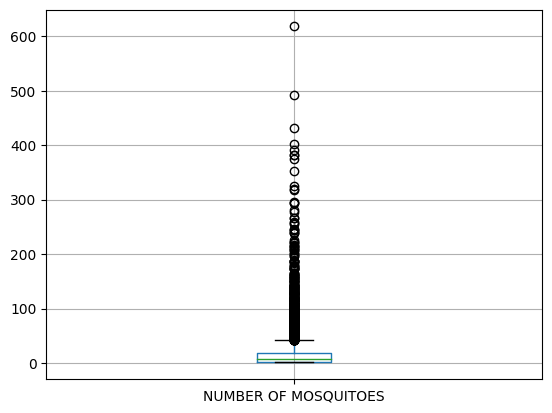

In [171]:
##distribution of the number of mosquitoes
df.boxplot(column='NUMBER OF MOSQUITOES')

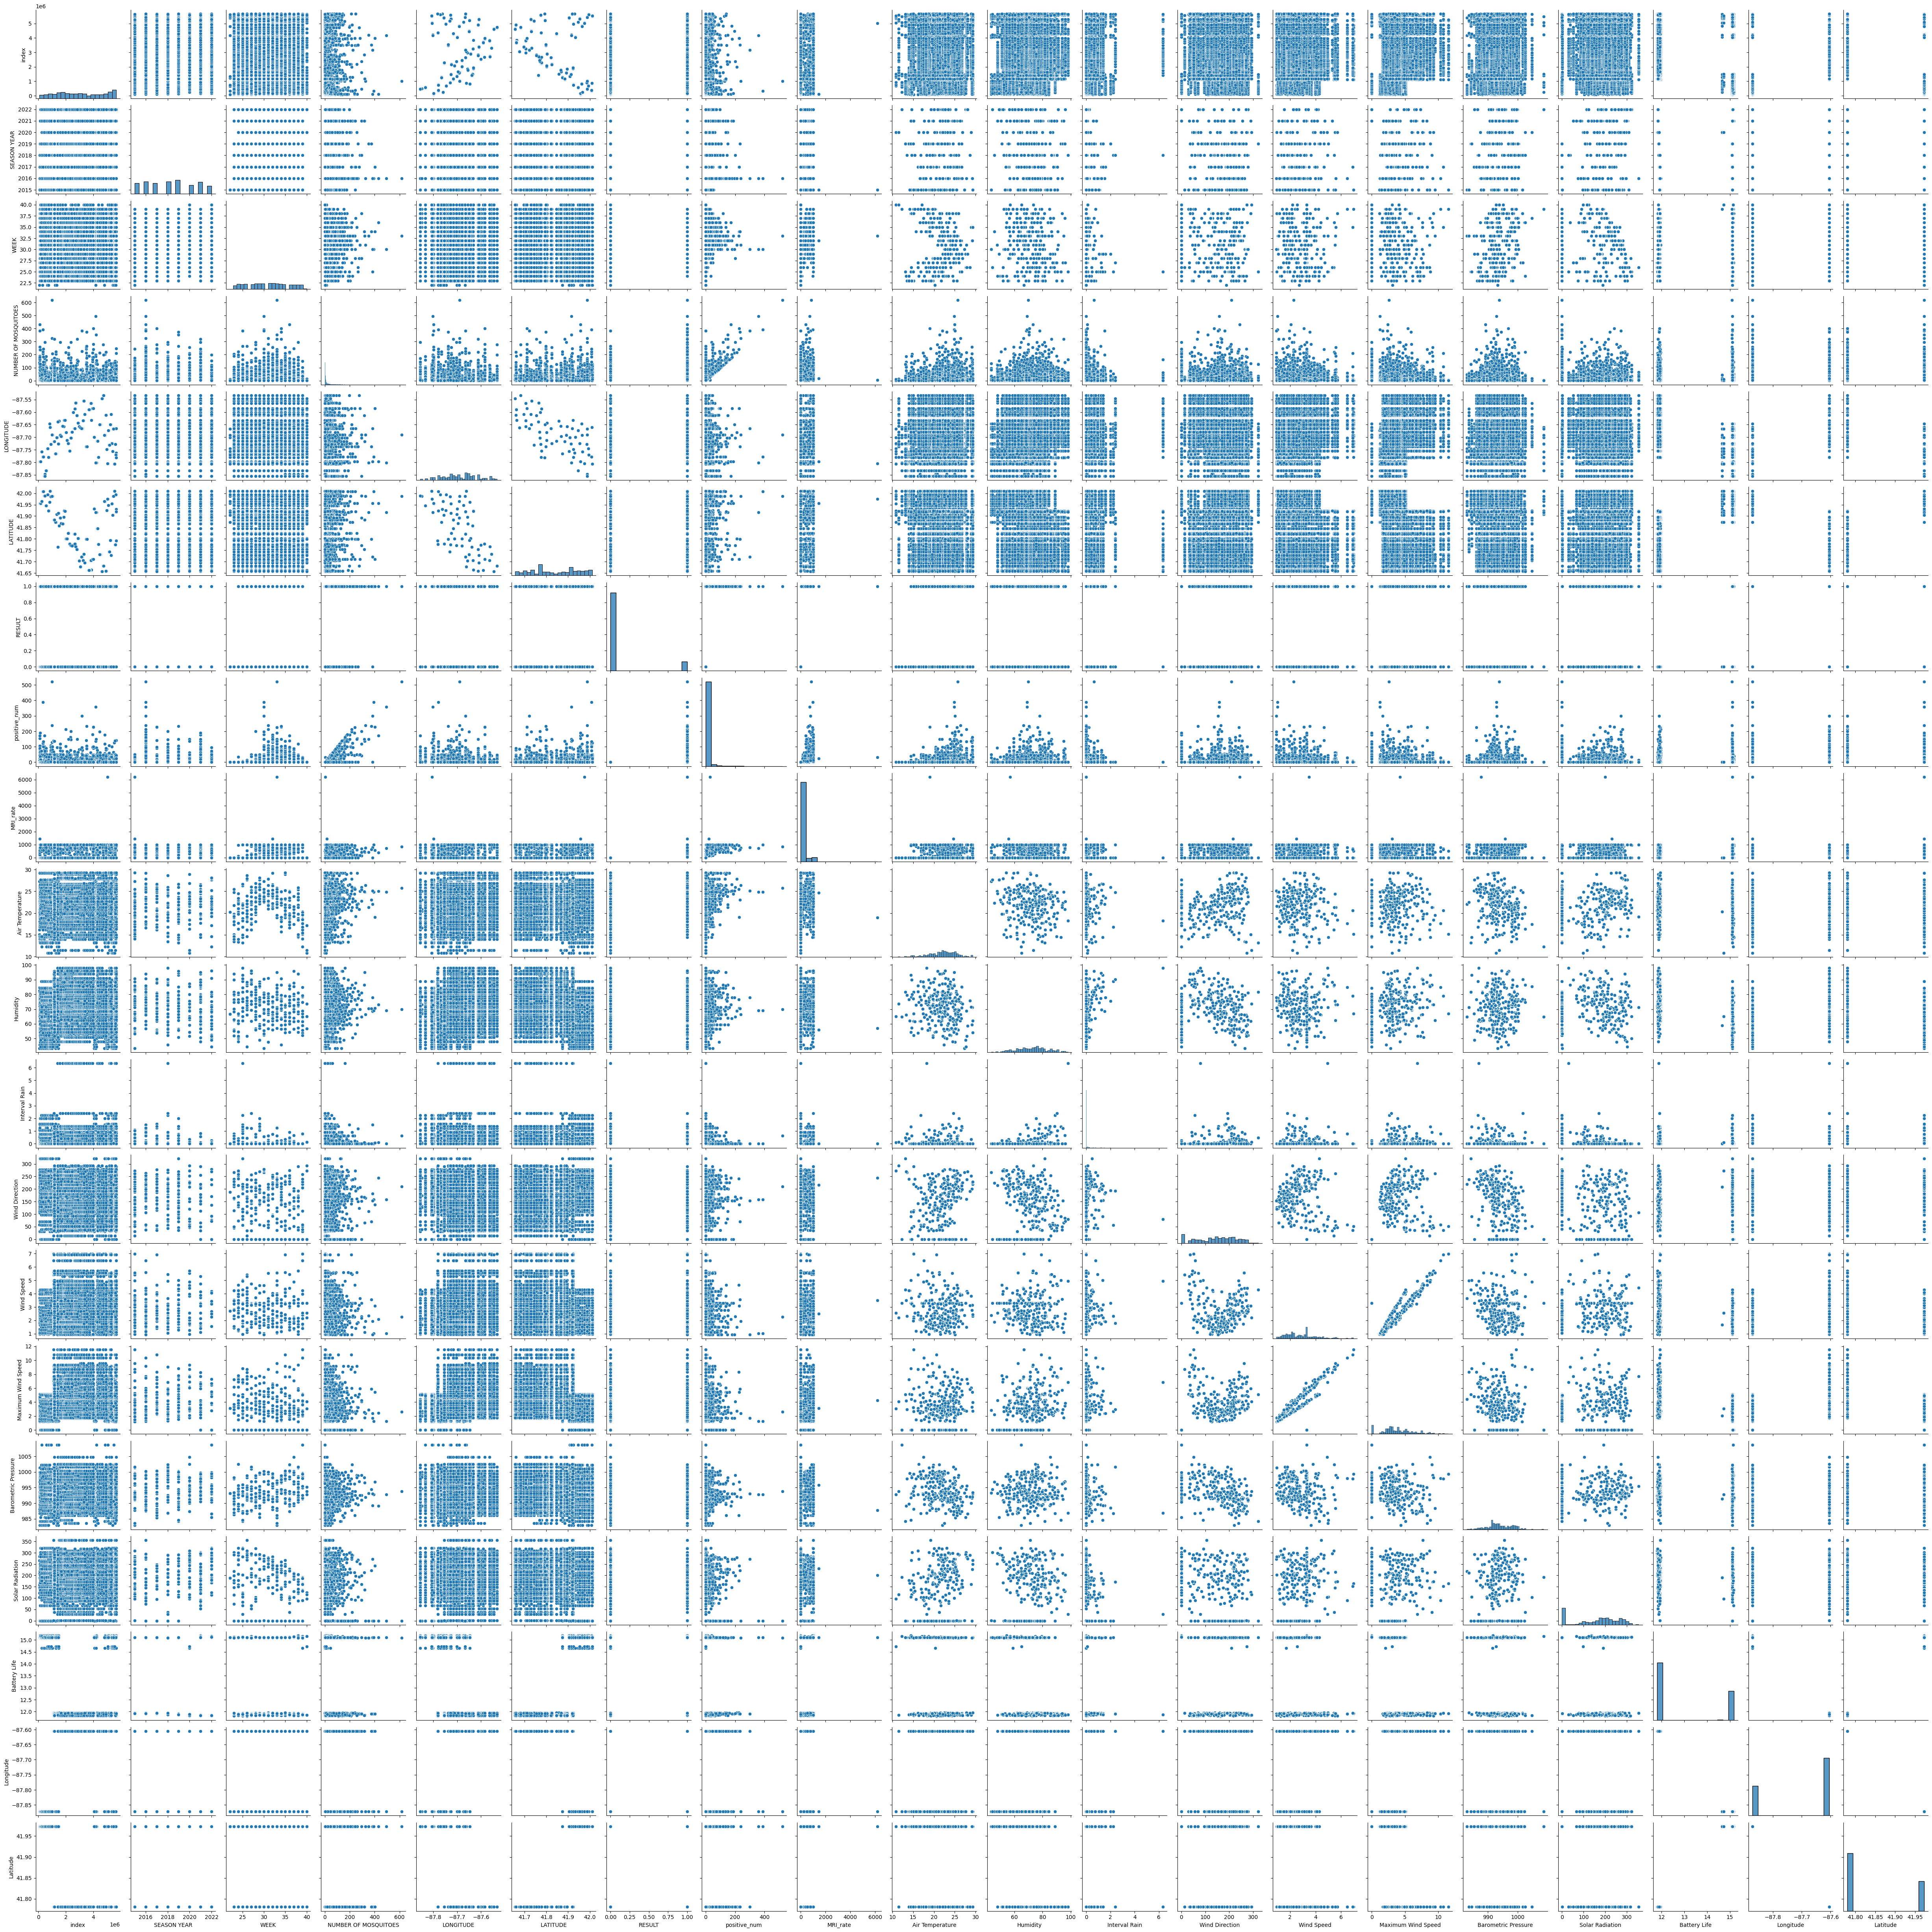

In [172]:
sns.pairplot(df)

<Axes: xlabel='NUMBER OF MOSQUITOES', ylabel='positive_num'>

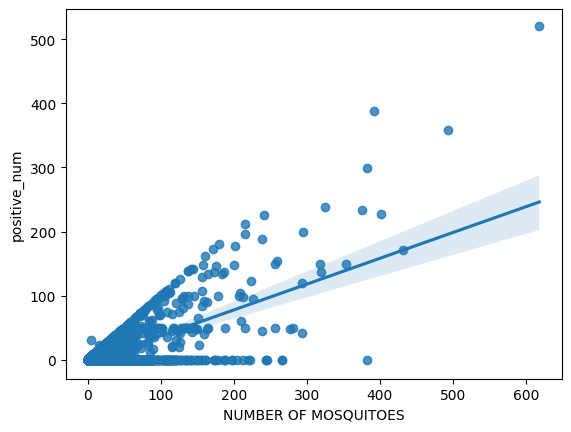

In [173]:
##most of these don't look related...
##number of mosquitoes seems to be positively correlated with positive_num: this makes sense
##i would expect that the more mosquitoes we have, the higher the number of positive mosquitoes will be
sns.regplot(x='NUMBER OF MOSQUITOES', y="positive_num", data=df)

In [174]:
##that outlier at about 600 mosquitoes is probably throwing everything for a loop
##now actually run some numbers and see how it looks
x = df['NUMBER OF MOSQUITOES'].values.reshape(-1, 1)
y = df["positive_num"].values.reshape(-1, 1)

In [175]:
##splitting data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4)

In [176]:
model = LinearRegression().fit(x_train, y_train)

In [177]:
## MSE:
y_pred_test = model.predict(x_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print("MSE:", mse_test)

MSE: 178.91301193280563


In [178]:
##and now R^2
r2 = model.score(x_test, y_test)
print("R-Squared:", r2)

R-Squared: 0.5536171779095201


In [179]:
##that is about the R^2 i expected-- they only seem slightly positively correlated

<Axes: xlabel='Air Temperature', ylabel='positive_num'>

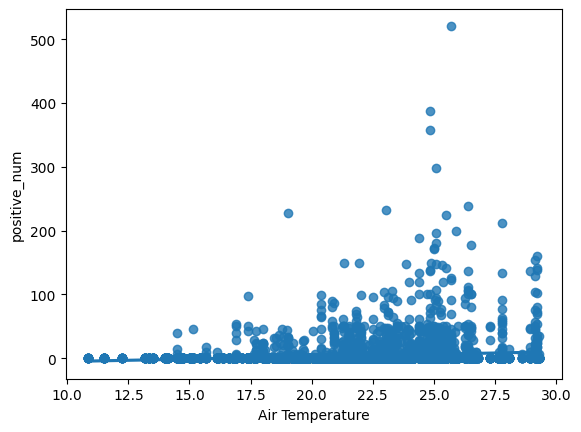

In [180]:
##positive_num vs air temperature looks like i could model it with a histogram-- skewed
sns.regplot(x='Air Temperature', y="positive_num", data=df)

<Axes: xlabel='Air Temperature', ylabel='positive_num'>

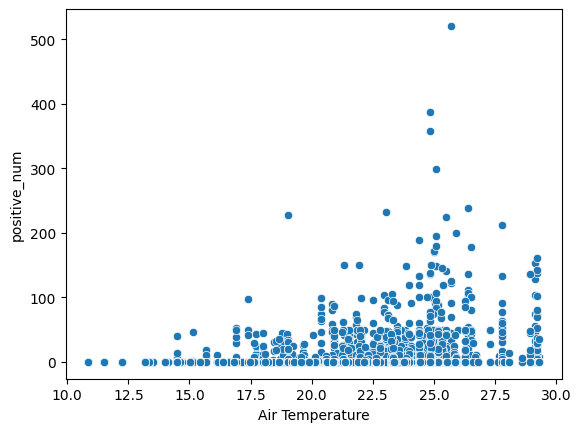

In [181]:
##we can see that Air Temperature vs positive_num is clearly skewed left and appears to be centered at 25.0
##this is interesting as a feel that we assume the warmer it is outside, the more mosquitoes have west nile
#but of course there's a threshold
sns.scatterplot(x='Air Temperature', y='positive_num', data=df)

In [182]:
##these were for earlier data set that we reduced. let's do a heat map for the final data frame:
df = pd.read_csv('final_data.csv')

<Axes: >

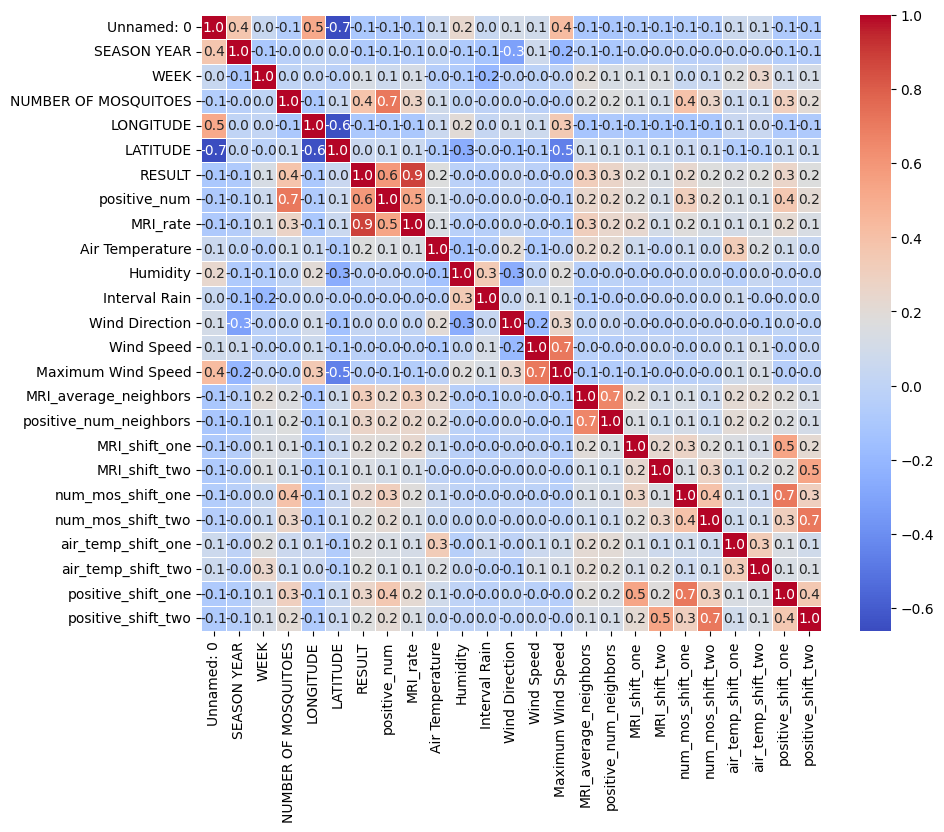

In [183]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.1f', linewidths=.5, annot_kws={"size": 10}, ax=ax)

In [184]:
##switch back to other data set:
df = pd.read_csv('wnv_weather.csv')
##bar graphs for top ten traps by average MIR_rate
grouped = df[df["SEASON YEAR"] == 2015]

In [185]:
trap_data = {}
for trap, mri_rate in zip(grouped["TRAP"], grouped["MRI_rate"]):
    if trap not in trap_data:
        trap_data[trap] = {"sum": mri_rate, "count": 1}
    else:
        trap_data[trap]["sum"] += mri_rate
        trap_data[trap]["count"] += 1

In [186]:
avg_mri_rate = [trap_data[trap]["sum"] / trap_data[trap]["count"] for trap in grouped["TRAP"]]
combined_data = list(zip(grouped["TRAP"], avg_mri_rate))
sorted_data = sorted(combined_data, key=lambda x: x[1], reverse=True)
top_10 = sorted(set(sorted_data), key=lambda x: x[1], reverse=True)[:10]
x_values = [x[0] for x in top_10]
y_values = [x[1] for x in top_10]

Text(0.5, 1.0, 'Top 10 Traps by Average MRI_rate -- 2015')

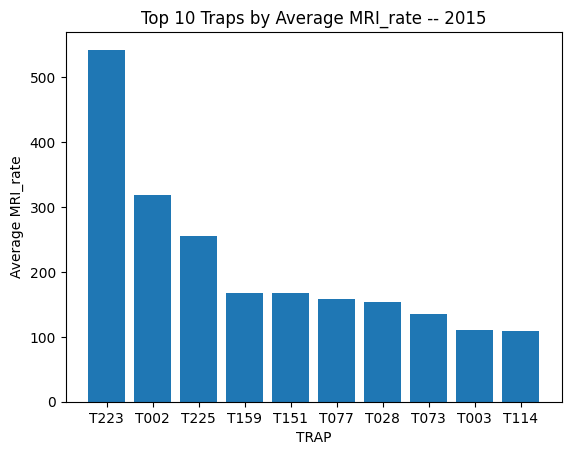

In [187]:
# Create the bar graph
plt.bar(x_values, y_values)

# Add labels and title
plt.xlabel("TRAP")
plt.ylabel("Average MRI_rate")
plt.title("Top 10 Traps by Average MRI_rate -- 2015")

In [188]:
##now 2016
grouped = df[df["SEASON YEAR"] == 2016]

In [189]:
trap_data = {}
for trap, mri_rate in zip(grouped["TRAP"], grouped["MRI_rate"]):
    if trap not in trap_data:
        trap_data[trap] = {"sum": mri_rate, "count": 1}
    else:
        trap_data[trap]["sum"] += mri_rate
        trap_data[trap]["count"] += 1

In [190]:
avg_mri_rate = [trap_data[trap]["sum"] / trap_data[trap]["count"] for trap in grouped["TRAP"]]
combined_data = list(zip(grouped["TRAP"], avg_mri_rate))
sorted_data = sorted(combined_data, key=lambda x: x[1], reverse=True)
top_10 = sorted(set(sorted_data), key=lambda x: x[1], reverse=True)[:10]
x_values = [x[0] for x in top_10]
y_values = [x[1] for x in top_10]

Text(0.5, 1.0, 'Top 10 Traps by Average MRI_rate -- 2016')

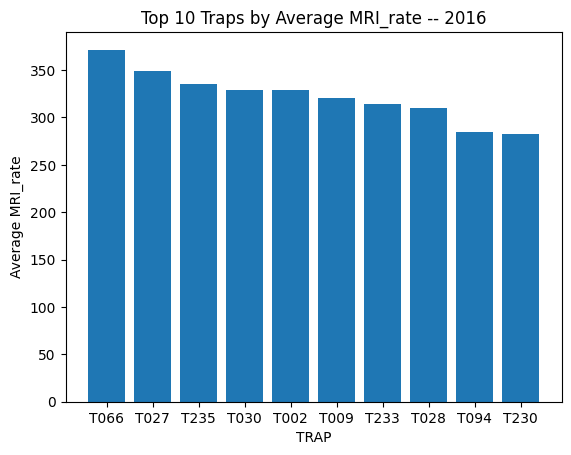

In [191]:
# Create the bar graph
plt.bar(x_values, y_values)

# Add labels and title
plt.xlabel("TRAP")
plt.ylabel("Average MRI_rate")
plt.title("Top 10 Traps by Average MRI_rate -- 2016")

In [192]:
##now 2021 -- we are doing two later years and two more recent years
grouped = df[df["SEASON YEAR"] == 2021]

In [193]:
trap_data = {}
for trap, mri_rate in zip(grouped["TRAP"], grouped["MRI_rate"]):
    if trap not in trap_data:
        trap_data[trap] = {"sum": mri_rate, "count": 1}
    else:
        trap_data[trap]["sum"] += mri_rate
        trap_data[trap]["count"] += 1

In [194]:
avg_mri_rate = [trap_data[trap]["sum"] / trap_data[trap]["count"] for trap in grouped["TRAP"]]
combined_data = list(zip(grouped["TRAP"], avg_mri_rate))
sorted_data = sorted(combined_data, key=lambda x: x[1], reverse=True)
top_10 = sorted(set(sorted_data), key=lambda x: x[1], reverse=True)[:10]
x_values = [x[0] for x in top_10]
y_values = [x[1] for x in top_10]

Text(0.5, 1.0, 'Top 10 Traps by Average MRI_rate -- 2021')

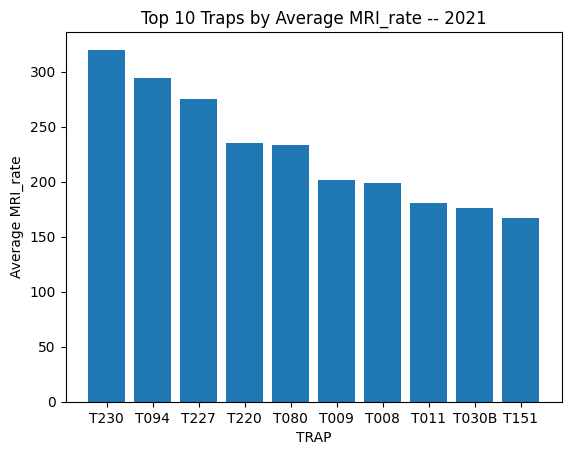

In [195]:
# Create the bar graph
plt.bar(x_values, y_values)

# Add labels and title
plt.xlabel("TRAP")
plt.ylabel("Average MRI_rate")
plt.title("Top 10 Traps by Average MRI_rate -- 2021")

In [196]:
##now 2022
grouped = df[df["SEASON YEAR"] == 2022]

In [197]:
trap_data = {}
for trap, mri_rate in zip(grouped["TRAP"], grouped["MRI_rate"]):
    if trap not in trap_data:
        trap_data[trap] = {"sum": mri_rate, "count": 1}
    else:
        trap_data[trap]["sum"] += mri_rate
        trap_data[trap]["count"] += 1

In [198]:
avg_mri_rate = [trap_data[trap]["sum"] / trap_data[trap]["count"] for trap in grouped["TRAP"]]
combined_data = list(zip(grouped["TRAP"], avg_mri_rate))
sorted_data = sorted(combined_data, key=lambda x: x[1], reverse=True)
top_10 = sorted(set(sorted_data), key=lambda x: x[1], reverse=True)[:10]
x_values = [x[0] for x in top_10]
y_values = [x[1] for x in top_10]

Text(0.5, 1.0, 'Top 10 Traps by Average MRI_rate -- 2022')

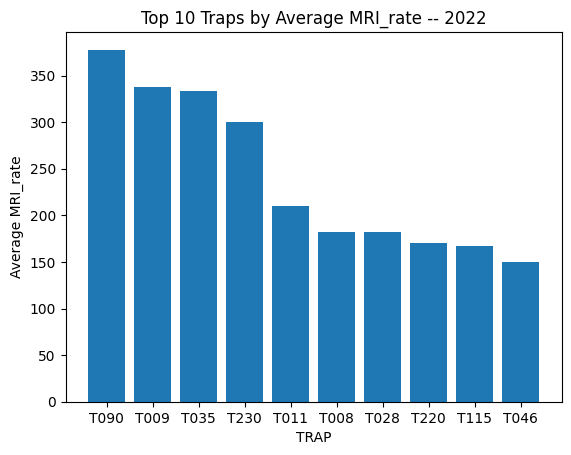

In [199]:
# Create the bar graph
plt.bar(x_values, y_values)

# Add labels and title
plt.xlabel("TRAP")
plt.ylabel("Average MRI_rate")
plt.title("Top 10 Traps by Average MRI_rate -- 2022")

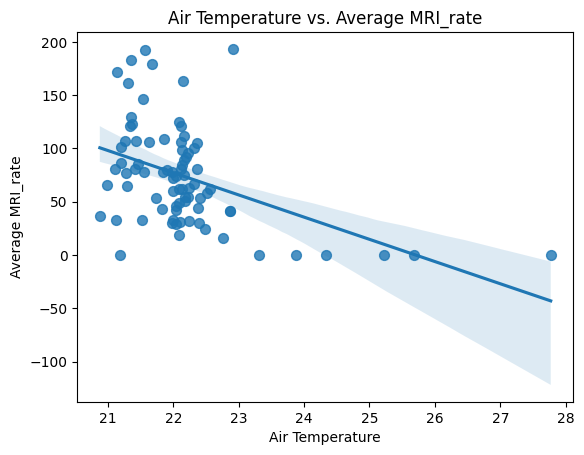

In [200]:
##let's look at how some things affect MIR_Rate
grouped_data = df.groupby('TRAP').mean().reset_index()
sns.regplot(x='Air Temperature', y='MRI_rate', data=grouped_data, scatter_kws={'s': 50}, line_kws={'label': 'Average MRI_rate'})

plt.title('Air Temperature vs. Average MRI_rate')
plt.xlabel('Air Temperature')
plt.ylabel('Average MRI_rate')
plt.show()

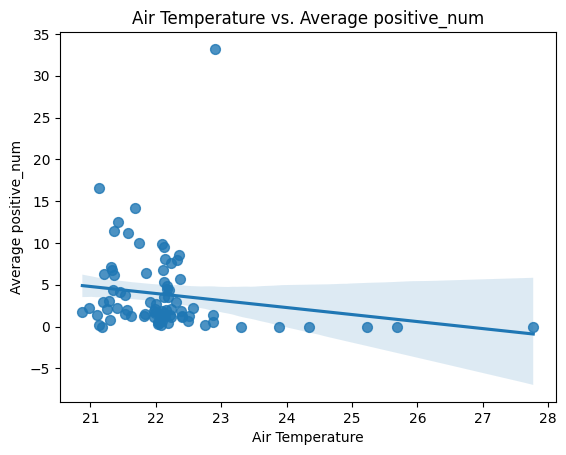

In [201]:
sns.regplot(x='Air Temperature', y='positive_num', data=grouped_data, scatter_kws={'s': 50}, line_kws={'label': 'Average positive_num'})

plt.title('Air Temperature vs. Average positive_num')
plt.xlabel('Air Temperature')
plt.ylabel('Average positive_num')
plt.show()

In [202]:
##i would expect to see more postive mosquitoes around 21-22 degrees C. this is also the strongest thing that affects MIR_rate in my opinion

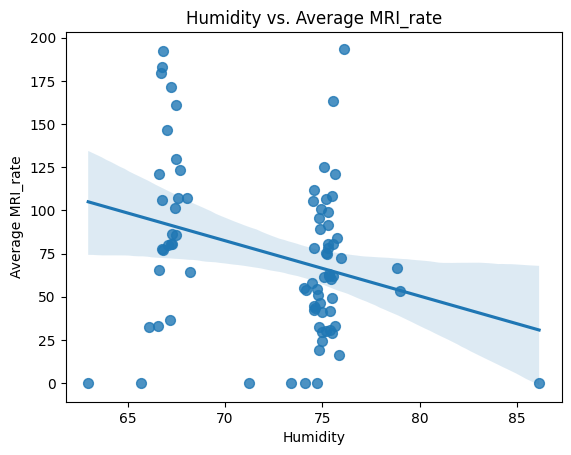

In [203]:
##now humidity:
sns.regplot(x='Humidity', y='MRI_rate', data=grouped_data, scatter_kws={'s': 50}, line_kws={'label': 'Average MRI_rate'})

plt.title('Humidity vs. Average MRI_rate')
plt.xlabel('Humidity')
plt.ylabel('Average MRI_rate')
plt.show()

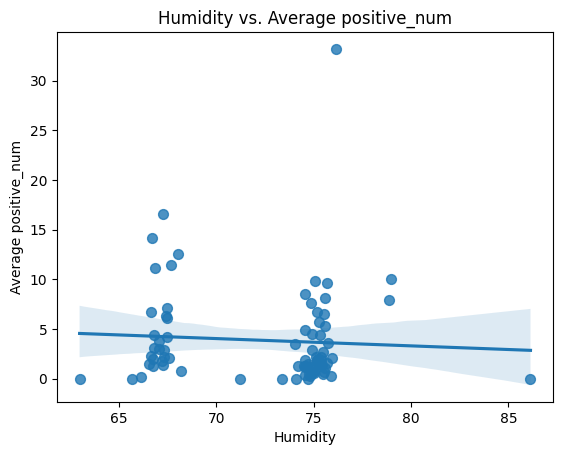

In [204]:
sns.regplot(x='Humidity', y='positive_num', data=grouped_data, scatter_kws={'s': 50}, line_kws={'label': 'Average positive_num'})

plt.title('Humidity vs. Average positive_num')
plt.xlabel('Humidity')
plt.ylabel('Average positive_num')
plt.show()

In [205]:
##it appears there is a strong dropoff of positive mosquitoes above 75% humidity

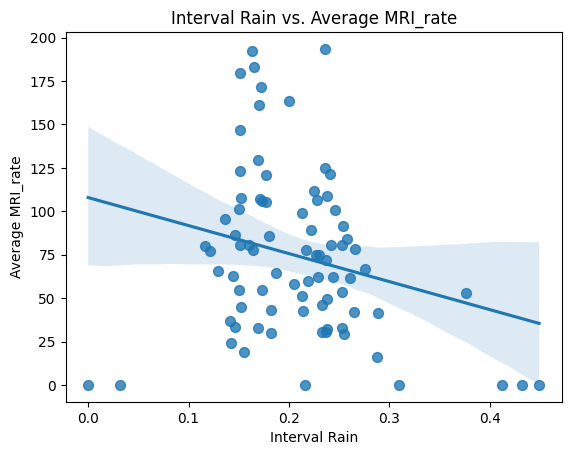

In [206]:
##and interval rain:
sns.regplot(x='Interval Rain', y='MRI_rate', data=grouped_data, scatter_kws={'s': 50}, line_kws={'label': 'Average MRI_rate'})

plt.title('Interval Rain vs. Average MRI_rate')
plt.xlabel('Interval Rain')
plt.ylabel('Average MRI_rate')
plt.show()

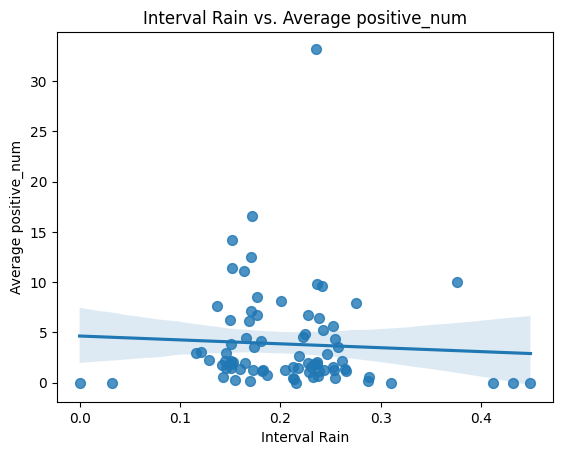

In [207]:
sns.regplot(x='Interval Rain', y='positive_num', data=grouped_data, scatter_kws={'s': 50}, line_kws={'label': 'Average positive_num'})

plt.title('Interval Rain vs. Average positive_num')
plt.xlabel('Interval Rain')
plt.ylabel('Average positive_num')
plt.show()

In [208]:
##it appears that in the 0.1 and 0.3 range of rain, so between 0.1 and 0.3 hours of raining, it is more likely that there will be positive mosquitoes, and it is more likely the average MRI_rate will be higher than 0

# Part 2. Model Building (Methodology)

Now that we have constructed and visualized our datasets we need to devise a method for making predictions.

This going to involve two major choices
1. Picking a model class
2. Picking features

You should expect to have to iterate back and forth between these two and to spend some time choosing features. You should also expect to spend some time optimizing your hyperparameters

We covered the following models in class 
1. Linear Regression
2. Nearest Neighbors
3. Decision Trees
4. Random Forests
5. Neural Networks

Feel free to use any of these, or any other model you want. You can check https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html for inspiration.


__Generating Features__:
1. __Lagged features__. All of our data (mosquito and weather data) are observed over time, which means you can use historical information to help predict current trap positivity. Research shows that the MIR, trap positivity, and weather information from one to several weeks back can be useful to predict trap positivity this week. Most mosquito models will include lagged weather variables at the minimum so you should strongly consider this.
 - For example if $t$ denotes the week then we may want to predict $\text{MIR}_t$ with $\text{MIR}_{t-1}, \text{MIR}_{t-2}, ...$
 - https://datascience.stackexchange.com/questions/72480/what-is-lag-in-time-series-forecasting 
2. __Spatial features__. Nearby traps are likely to be correlated. Consider including MIR, trap positivity, weather data, etc. from nearby traps in your prediction model as well. For example, try including the MIR from the 5 nearest neighbors in your model.
   - For example if $t$ denotes the week and $s$ denotes a trap location then then we may want to predict $\text{MIR}_{t, s}$ with $\text{MIR}_{t-1, s^*}, \text{MIR}_{t-2, s^*}, ...$ where $s^*$ is some nearby trap.


__Sample Splitting__:
Make sure to reserve some data for validation and testing. If you use lagged features (and you should) then make sure when you train/val/test split that you split the data into contiguous blocks. Otherwise test data can leak into your training data via the lagged features.
 - Leave at least 1 year of data for testing





## 2.1 Spatial features


In [209]:
#only getting the unique traps 
result_match = result.drop_duplicates('TRAP')

In [210]:
#using ball tree to find the 5-nearest neighbots
from sklearn.neighbors import BallTree, KDTree
column_names = ["TRAP", "LATITUDE", "LONGITUDE"]
locations_a = result_match[['TRAP','LATITUDE','LONGITUDE']]
locations_b = result_match[['TRAP','LATITUDE','LONGITUDE']]
# Creates new columns converting coordinate degrees to radians.
for column in locations_a[["LATITUDE", "LONGITUDE"]]:
    rad = np.deg2rad(locations_a[column].values)
    locations_a[f'{column}_rad'] = rad
for column in locations_b[["LATITUDE", "LONGITUDE"]]:
    rad = np.deg2rad(locations_b[column].values)
    locations_b[f'{column}_rad'] = rad
# Takes the first group's latitude and longitude values to construct
# the ball tree.
ball = BallTree(locations_a[["LATITUDE_rad", "LONGITUDE_rad"]].values, metric='haversine')
# The amount of neighbors to ret3urn.
k = 6
# Executes a query with the second group. This will also return two
# arrays.
distances, indices = ball.query(locations_b[["LATITUDE_rad", "LONGITUDE_rad"]].values, k = k)

In [211]:
#remove the first index since it is always will be matched with itself
indices = [i[1:] for i in indices]
distances = [i[1:] for i in distances]

In [212]:
#Turn index and distance into dataframe and merge
index_array = pd.DataFrame(indices).reset_index()
distance_array = pd.DataFrame(distances).reset_index()
index_dist = index_array.merge(distance_array, how='inner',on='index')

In [213]:
result_match = result_match.reset_index()
# Assign correct trap to the index_dist dataframe
trap = list(result_match['TRAP'])
index_dist['TRAP'] = trap

In [214]:
#match the index with nearest Trap
# need to check for accuracy with this logic. Seems correct-ish?
for i in range(len(trap)):
  for j in range(len(trap)):
    if index_dist['0_x'][j] == i:
      index_dist['0_x'][j] = trap[i]

for i in range(len(trap)):
  for j in range(len(trap)):
    if index_dist['1_x'][j] == i:
      index_dist['1_x'][j] = trap[i]

for i in range(len(trap)):
  for j in range(len(trap)):
    if index_dist['2_x'][j] == i:
      index_dist['2_x'][j] = trap[i]

for i in range(len(trap)):
  for j in range(len(trap)):
    if index_dist['3_x'][j] == i:
      index_dist['3_x'][j] = trap[i]

for i in range(len(trap)):
  for j in range(len(trap)):
    if index_dist['4_x'][j] == i:
      index_dist['4_x'][j] = trap[i]

In [215]:
final_res = result.merge(index_dist,how='left',on='TRAP')
final_res.head()
final_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6653 entries, 0 to 6652
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TRAP                  6653 non-null   object 
 1   SEASON YEAR           6653 non-null   int64  
 2   WEEK                  6653 non-null   int64  
 3   NUMBER OF MOSQUITOES  6653 non-null   int64  
 4   Date                  6653 non-null   object 
 5   BLOCK_y               6653 non-null   object 
 6   LONGITUDE             6653 non-null   float64
 7   LATITUDE              6653 non-null   float64
 8   RESULT                6653 non-null   bool   
 9   positive_num          6653 non-null   int64  
 10  MRI_rate              6653 non-null   float64
 11  Station Name          6653 non-null   object 
 12  Air Temperature       6653 non-null   float64
 13  Humidity              6653 non-null   float64
 14  Interval Rain         6653 non-null   float64
 15  Wind Direction       

In [216]:
# match the average MRI + positive num of the 5 neighbors with the matching trapn
from statistics import mean
temp_dict = {}
final_res_dict = []
list_0x_to_5x = []
for i in range(len(final_res)):
  cur_line = final_res.iloc[i].tolist()
  final_res_dict.append(cur_line[0:3])
  list_0x_to_5x.append(cur_line[22:27])
  hash_key = cur_line[0]+str(cur_line[1])+str(cur_line[2])
  temp_dict[hash_key] = [cur_line[10],cur_line[9]]

for i in range(len(final_res)):
  for index in range(0,2):
    field_val = []
    for j in range(0,5):
      x_value = [list_0x_to_5x[i][j]]
      x_value.append(final_res_dict[i][1])
      x_value.append(final_res_dict[i][2])
      hash_key = list_0x_to_5x[i][j]+str(final_res_dict[i][1])+str(final_res_dict[i][2])
      if hash_key in temp_dict:
        field_val.append(temp_dict[hash_key][index])
    if len(field_val)==0:
      field_val_avg = 0.0
    else:
      field_val_avg = mean(field_val)
    final_res_dict[i].append(field_val_avg)

for i in range (0,100):
  print(final_res_dict[i])

final_res_dict = pd.DataFrame(final_res_dict)

['T002', 2015, 22, 0.0, 0]
['T008', 2015, 22, 0.0, 0]
['T012', 2015, 22, 0.0, 0]
['T013', 2015, 22, 0.0, 0]
['T031', 2015, 22, 0.0, 0]
['T033', 2015, 22, 0.0, 0.0]
['T151', 2015, 22, 0.0, 0]
['T220', 2015, 22, 0.0, 0]
['T230', 2015, 22, 0.0, 0]
['T231', 2015, 22, 0.0, 0]
['T233', 2015, 22, 0.0, 0]
['T236', 2015, 22, 0.0, 0]
['T002', 2015, 23, 0.0, 0]
['T009', 2015, 23, 0.0, 0]
['T011', 2015, 23, 0.0, 0]
['T012', 2015, 23, 0.0, 0]
['T013', 2015, 23, 0.0, 0]
['T028', 2015, 23, 0.0, 0]
['T031', 2015, 23, 0.0, 0]
['T033', 2015, 23, 0.0, 0.0]
['T151', 2015, 23, 0.0, 0]
['T220', 2015, 23, 0.0, 0]
['T222', 2015, 23, 0.0, 0]
['T223', 2015, 23, 0.0, 0]
['T224', 2015, 23, 0.0, 0]
['T228', 2015, 23, 0.0, 0]
['T230', 2015, 23, 0.0, 0]
['T231', 2015, 23, 0.0, 0]
['T233', 2015, 23, 0.0, 0]
['T236', 2015, 23, 0.0, 0]
['T002', 2015, 24, 0.0, 0]
['T003', 2015, 24, 0.0, 0]
['T008', 2015, 24, 0.0, 0]
['T009', 2015, 24, 0.0, 0]
['T011', 2015, 24, 0.0, 0]
['T012', 2015, 24, 0.0, 0]
['T013', 2015, 24, 0.0, 

In [217]:
final_res_dict.rename(columns={0:'TRAP',1:'SEASON YEAR',2:'WEEK',3:'MRI_average_neighbors',4:'positive_num_neighbors'},inplace=True)

In [218]:
final_res = final_res.merge(final_res_dict, how='inner',on=['TRAP','SEASON YEAR','WEEK'])

In [219]:
# drop irrelevant columns
final_res = final_res.drop(['0_y','1_y', '2_y', '3_y', '4_y','0_x', '1_x', '2_x', '3_x', '4_x'],axis=1)

##2.2 Lagged Features

In [220]:
# attempting to create time lags based on functions
def generate_time_lags(df, n_lags, col_shift):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[col_shift+f"{n}"] = df_n.groupby('TRAP')[col_shift].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n
    
input_dim = 5

df_generated = generate_time_lags(final_res, input_dim, 'MRI_rate')
df_generated = generate_time_lags(df_generated, input_dim, 'NUMBER OF MOSQUITOES')
df_generated = generate_time_lags(df_generated, input_dim, 'positive_num')
df_generated = generate_time_lags(df_generated, input_dim, 'Air Temperature')
df_generated = generate_time_lags(df_generated, input_dim, 'MRI_average_neighbors')
df_generated = generate_time_lags(df_generated, input_dim, 'positive_num_neighbors')


df_generated.head(10)

TRAP  SEASON YEAR  WEEK  NUMBER OF MOSQUITOES        Date  \
30  T002         2015    24                   128  2015-06-18   
31  T003         2015    24                     3  2015-06-18   
32  T008         2015    24                     8  2015-06-18   
33  T009         2015    24                    12  2015-06-18   
34  T011         2015    24                     8  2015-06-18   
35  T012         2015    24                     2  2015-06-18   
36  T013         2015    24                    18  2015-06-18   
37  T017         2015    24                     2  2015-06-18   
38  T027         2015    24                     6  2015-06-18   
39  T028         2015    24                    74  2015-06-18   

                  BLOCK_y  LONGITUDE   LATITUDE  RESULT  positive_num  ...  \
30    41XX N OAK PARK AVE -87.797517  41.956299   False             0  ...   
31   46XX N MILWAUKEE AVE -87.758412  41.965375   False             0  ...   
32     70XX N MOSELLE AVE -87.778235  42.007998   False             0  ...   
33      91XX W HIGGINS RD -87.854473  41.988586   False             0  ...   
34  36XX N PITTSBURGH AVE -87.832942  41.945961   False             0  ...   
35      61XX N LEMONT AVE -87.745420  41.993564   False             0  ...   
36   61XX W FULLERTON AVE -87.778910  41.923887   False             0  ...   
37      6XX W MONTROSE DR -87.646848  41.962015   False             0  ...   
38      58XX N PULASKI RD -87.728378  41.986320   False             0  ...   
39     58XX N WESTERN AVE -87.689417  41.987245   False             0  ...   

    MRI_average_neighbors1 MRI_average_neighbors2  MRI_average_neighbors3  \
30                     NaN                    NaN                     NaN   
31                     NaN                    NaN                     NaN   
32                     NaN                    NaN                     NaN   
33                     NaN                    NaN                     NaN   
34                     NaN                    NaN                     NaN   
35                     NaN                    NaN                     NaN   
36                     NaN                    NaN                     NaN   
37                     NaN                    NaN                     NaN   
38                     NaN                    NaN                     NaN   
39                     NaN                    NaN                     NaN   

    MRI_average_neighbors4  MRI_average_neighbors5  positive_num_neighbors1  \
30                     NaN                     NaN                      NaN   
31                     NaN                     NaN                      NaN   
32                     NaN                     NaN                      NaN   
33                     NaN                     NaN                      NaN   
34                     NaN                     NaN                      NaN   
35                     NaN                     NaN                      NaN   
36                     NaN                     NaN                      NaN   
37                     NaN                     NaN                      NaN   
38                     NaN                     NaN                      NaN   
39                     NaN                     NaN                      NaN   

    positive_num_neighbors2  positive_num_neighbors3  positive_num_neighbors4  \
30                      NaN                      NaN                      NaN   
31                      NaN                      NaN                      NaN   
32                      NaN                      NaN                      NaN   
33                      NaN                      NaN                      NaN   
34                      NaN                      NaN                      NaN   
35                      NaN                      NaN                      NaN   
36                      NaN                      NaN                      NaN   
37                      NaN                      NaN           

In [221]:
df_generated.columns.values
df_generated.dropna(axis='rows',inplace=True)
data_curr_MRI = df_generated

In [222]:

# match the average MRI + positive num of the 5 neighbors with the matching trapn
from statistics import mean


temp_dict = {}
final_res_dict = []
list_0x_to_5x = []

for i in range(len(data_curr_MRI)):
  cur_line = data_curr_MRI.iloc[i].tolist()
  final_res_dict.append(cur_line[0:3])
  hash_key = cur_line[0]+str(cur_line[1])+str(cur_line[2])
  temp_dict[hash_key] = cur_line[10]
  # MRI, positive_num

for i in range(len(data_curr_MRI)):
  cur_line = data_curr_MRI.iloc[i].tolist()
  next_week = cur_line[2] + 1
  next_week_year = cur_line[1]
  next_next_week = cur_line[2] + 2
  next_next_week_year = cur_line[1]
  if next_week>52:
    next_week=1
    next_week_year += 1
  if next_next_week>52:
    next_next_week =1
    next_next_week_year += 1
  next_week_hash_key = cur_line[0]+str(next_week_year)+str(next_week)
  next_next_week_hash_key =  cur_line[0]+str(next_next_week_year)+str(next_next_week)
  for hash_key in [next_week_hash_key, next_next_week_hash_key]:
    if hash_key in temp_dict:
      final_res_dict[i].append(temp_dict[hash_key])
    else:
      final_res_dict[i].append(0.0)

for i in range (0,100):
  print(final_res_dict[i])

final_res_dict = pd.DataFrame(final_res_dict)


['T228', 2015, 28, 0.0, 515.4639175257731]
['T233', 2015, 28, 0.0, 0.0]
['T236', 2015, 28, 0.0, 0.0]
['T002', 2015, 29, 0.0, 260.8695652173913]
['T008', 2015, 29, 0.0, 0.0]
['T009', 2015, 29, 0.0, 0.0]
['T011', 2015, 29, 0.0, 0.0]
['T012', 2015, 29, 0.0, 0.0]
['T013', 2015, 29, 0.0, 0.0]
['T027', 2015, 29, 0.0, 0.0]
['T028', 2015, 29, 0.0, 0.0]
['T151', 2015, 29, 777.7777777777778, 461.53846153846155]
['T223', 2015, 29, 368.4210526315789, 0.0]
['T228', 2015, 29, 515.4639175257731, 0.0]
['T230', 2015, 29, 0.0, 0.0]
['T231', 2015, 29, 0.0, 0.0]
['T233', 2015, 29, 0.0, 0.0]
['T236', 2015, 29, 0.0, 0.0]
['T002', 2015, 30, 260.8695652173913, 1000.0]
['T003', 2015, 30, 0.0, 1000.0]
['T008', 2015, 30, 0.0, 0.0]
['T009', 2015, 30, 0.0, 0.0]
['T011', 2015, 30, 0.0, 0.0]
['T012', 2015, 30, 0.0, 0.0]
['T013', 2015, 30, 0.0, 500.0]
['T027', 2015, 30, 0.0, 0.0]
['T028', 2015, 30, 0.0, 0.0]
['T031', 2015, 30, 0.0, 0.0]
['T147', 2015, 30, 0.0, 0.0]
['T151', 2015, 30, 461.53846153846155, 181.818181818

In [223]:
final_res_dict.rename(columns={0:'TRAP',1:'SEASON YEAR',2:'WEEK',3:'MRI_next_week',4:'MRI_next2_week'},inplace=True)

In [224]:
final_res = data_curr_MRI.merge(final_res_dict, how='inner',on=['TRAP','SEASON YEAR','WEEK'])

In [225]:
final_res.dropna(axis='rows',inplace=True)
final_res.drop_duplicates()

TRAP  SEASON YEAR  WEEK  NUMBER OF MOSQUITOES        Date  \
0     T228         2015    28                    75  2015-07-16   
1     T233         2015    28                   104  2015-07-16   
2     T236         2015    28                    23  2015-07-16   
3     T002         2015    29                    64  2015-07-23   
4     T008         2015    29                    23  2015-07-23   
...    ...          ...   ...                   ...         ...   
6343  T221         2020    24                    18  2020-06-11   
6344  T231         2016    33                    24  2016-08-19   
6348  T231         2016    33                    24  2016-08-19   
6352  T231         2016    33                     4  2016-08-19   
6356  T231         2016    33                     4  2016-08-19   

                     BLOCK_y  LONGITUDE   LATITUDE  RESULT  positive_num  ...  \
0     39XX N SPRINGFIELD AVE -87.724987  41.953664   False             0  ...   
1          71XX N HARLEM AVE -87.806797  42.010643   False             0  ...   
2       62XX N MCCLELLAN AVE -87.770837  41.994966   False             0  ...   
3        41XX N OAK PARK AVE -87.797517  41.956299   False             0  ...   
4         70XX N MOSELLE AVE -87.778235  42.007998   False             0  ...   
...                      ...        ...        ...     ...           ...  ...   
6343          4XX E 130TH ST -87.612015  41.659236   False             0  ...   
6344        58XX N RIDGE AVE -87.666785  41.987881   False             0  ...   
6348        58XX N RIDGE AVE -87.666785  41.987881   False             0  ...   
6352        58XX N RIDGE AVE -87.666785  41.987881   False             0  ...   
6356        58XX N RIDGE AVE -87.666785  41.987881   False             0  ...   

      MRI_average_neighbors3 MRI_average_neighbors4  MRI_average_neighbors5  \
0                   0.000000               0.000000                     0.0   
1                   0.000000               0.000000                     0.0   
2                   0.000000               0.000000                     0.0   
3                   0.000000               0.000000                     0.0   
4                   0.000000               0.000000                     0.0   
...                      ...                    ...                     ...   
6343                0.000000               0.000000                     0.0   
6344                0.000000               0.000000                   850.0   
6348                0.000000               0.000000                     0.0   
6352              428.571429               0.000000                     0.0   
6356              210.760518             428.571429                     0.0   

      positive_num_neighbors1  positive_num_neighbors2  \
0                         0.0                      0.0   
1                         0.0                      0.0   
2                         0.0                      0.0   
3                         0.0                      0.0   
4                         0.0                      0.0   
...                       ...                      ...   
6343                      0.0                      0.0   
6344                      9.0                      0.0   
6348                    130.0                      9.0   
6352                    130.0                    130.0   
6356                    130.0                    130.0   

      positive_num_neighbors3  positive_num_neighbors4  \
0                         0.0                      0.0   
1                         0.0                      0.0   
2                         0.0                      0.0   
3                         0.0                      0.0   
4                         0.0                      0.0   
...                       ...                      ...   
6343                      0.0                      0.0   
6344                      0.0                      0.0   
6348                      0.0                      0.0   
63

##2.2.1 Check for imbalance data (hint: it is IMBALANCE!)

This is telling that our data is imbalance, with about 89% of the result is negative (MRI = 0) and only about 11% are positive (MRI > 1). 

In [226]:
#see how many rows that our MRI_rate is = 0.0
num_negative = len(data_curr_MRI[data_curr_MRI['MRI_rate']==0.000])
print('Percentage of negative result (MRI=0):',num_negative/len(data_curr_MRI)*100)

Percentage of negative result (MRI=0): 88.62763915547025


In [227]:
# see how many rows are our MRI_rate is positive (only 721)
num_positive = len(data_curr_MRI[data_curr_MRI['MRI_rate']>1].value_counts())
print('Percentage of negative result (MRI>1):',num_positive/len(data_curr_MRI)*100)

Percentage of negative result (MRI>1): 11.372360844529751


##2.2 Data pre-process + splitting

In [228]:
# some models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# and other tools
from sklearn import metrics
from sklearn.model_selection import train_test_split
# model fitting
# import all the libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

In [229]:
rs = np.random.RandomState(0)
corr = final_res.corr()
corr = pd.DataFrame(corr['MRI_next_week'])
corr.style.background_gradient(cmap='coolwarm')

In [230]:
# creating feature variables (for the compact dataset)
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scale= StandardScaler()
final_res = final_res.sort_values(by=['SEASON YEAR','WEEK']) #order by Date so our data is continous
X = final_res.drop(['TRAP','MRI_rate','BLOCK_y','Station Name','Date','MRI_next_week','MRI_next2_week'],axis=1)
y = final_res['MRI_rate']

X_next = final_res[['SEASON YEAR','WEEK','NUMBER OF MOSQUITOES1','NUMBER OF MOSQUITOES','NUMBER OF MOSQUITOES2','RESULT','positive_num','Air Temperature',
                    'MRI_average_neighbors','positive_num_neighbors','MRI_rate1','MRI_rate2','positive_num1','Air Temperature1',
                    'positive_num2','MRI_average_neighbors1','WEEK','LONGITUDE','LATITUDE']]
y_next = final_res['MRI_next_week']
X_next2 = final_res[['SEASON YEAR','NUMBER OF MOSQUITOES1','NUMBER OF MOSQUITOES','RESULT','positive_num','Air Temperature',
                    'MRI_average_neighbors','positive_num_neighbors','MRI_rate1','MRI_rate2','positive_num1','Air Temperature1',
                     'LONGITUDE','LATITUDE']]
y_next2 = final_res['MRI_next2_week']

In [231]:
X, X_test, y, y_test = train_test_split(X,y,test_size=0.2,train_size=0.8, shuffle=False)
X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size = 0.25,train_size =0.75, shuffle=False)

X, X_test1, y, y_test1 = train_test_split(X_next,y_next,test_size=0.2,train_size=0.8, shuffle=False)
X_train1, X_cv1, y_train1, y_cv1 = train_test_split(X,y,test_size = 0.25,train_size =0.75,shuffle=False)

X, X_test2, y, y_test2 = train_test_split(X_next2,y_next2,test_size=0.2,train_size=0.8,shuffle=False)
X_train2, X_cv2, y_train2, y_cv2 = train_test_split(X,y,test_size = 0.25,train_size =0.75,shuffle=False)

## 2.3 Multiple Linear Regression

In [232]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
# model testing
model = LinearRegression()
# fitting the model
model.fit(X_train,y_train)

LinearRegression()

In [233]:
# Saving the predictions
predictions_mlr = model.predict(X_test)
predictions_mlr= pd.DataFrame(predictions_mlr, columns=['predicted_fire_size'])

In [234]:
# model evaluation
mse = mean_squared_error(y_test, predictions_mlr)
r2 = r2_score(y_test, predictions_mlr)
mae = mean_absolute_error(y_test, predictions_mlr)
# Print the mean squared error and R-squared score
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared score:", r2)

Mean Squared Error: 40049.35910667873
Mean Absolute Error: 153.89526956462507
R-squared score: 0.5332606751811053


## 2.4 K-nearest neighbors

In [235]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [236]:
predictions_knn = knn_model.predict(X_test)
predictions__knn_df= pd.DataFrame(predictions_knn, columns=['predicted_fire_size'])

In [237]:
mse = mean_squared_error(y_test, predictions_knn)
r2 = r2_score(y_test, predictions_knn)
mae = mean_absolute_error(y_test, predictions_knn)
# Print the mean squared error and R-squared score
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared score:", r2)

Mean Squared Error: 91436.9749724165
Mean Absolute Error: 139.6882391621302
R-squared score: -0.06561585288866434


## 2.5 Decision Trees


In [238]:
#import the libraries
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [239]:
# creating model
reg_model = DecisionTreeRegressor(random_state=42)
reg_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [240]:
# Saving the predictions
prediction_dt = reg_model.predict(X_test)
prediction_df= pd.DataFrame(prediction_dt, columns=['MRI_rate'])
print(prediction_df.head(5))

     MRI_rate
0  939.393939
1    0.000000
2    0.000000
3    0.000000
4    0.000000


In [241]:
mse = mean_squared_error(y_test, prediction_dt)
r2 = r2_score(y_test, prediction_dt)
mae = mean_absolute_error(y_test, prediction_dt)
# Print the mean squared error and R-squared score
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared score:", r2)

Mean Squared Error: 205851.63575251587
Mean Absolute Error: 51.94270363006599
R-squared score: -1.399016004927078


##2.6 Random Forest

In [242]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [243]:
# Apply random forest model
negative_ratio = 9
class_weight = {0: 1, 1: negative_ratio}
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [244]:
y_pred_rf = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
# Print the mean squared error and R-squared score
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared score:", r2)

Mean Squared Error: 59510.30739373147
Mean Absolute Error: 35.015505167969266
R-squared score: 0.3064607945727865


In [245]:
scores = cross_val_score(rf_model, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
# 0.93 accuracy -> pretty bad?

0.93 accuracy with a standard deviation of 0.06


## 2.7 XGBOOST

In [246]:
from numpy import loadtxt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputRegressor

In [247]:
# fit model no training data

scale_pos_weight = 9
#xgb_model = XGBRegressor(eta=0.2,booster='gblinear',eval_metric='rmsle')
#xgb_model = XGBRegressor(eval_metric='rmse',eta=0.0001,reg_lambda=0.5,tree_method='exact',scale_pos_weight=9,
                         #n_estimators=1000)
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [248]:
xgb_model1 = XGBRegressor()
xgb_model1.fit(np.array(X_train1), y_train1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [249]:
# make predictions for test data
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_next = xgb_model1.predict(X_test1)
y_pred_xgb = [0 if i < 0 else i for i in y_pred_xgb]
predictions_xgb = [round(value) for value in y_pred_xgb]
#predictions = [0.000 if i < 0 else i for i in predictions]

In [250]:
mse = mean_squared_error(y_test, predictions_xgb)
r2 = r2_score(y_test, predictions_xgb)
mae = mean_absolute_error(y_test, predictions_xgb)
# Print the mean squared error and R-squared score
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared score:", r2)
# MSE: 823.5 #new MSE: 353.496 #MSE: 172.59
# MAE: 5.74 #new MAE: 4.3439 
# R^2: 0.986 #new R^2: 0.99

Mean Squared Error: 1281.8207595152592
Mean Absolute Error: 9.378488527034875
R-squared score: 0.9850615298426779


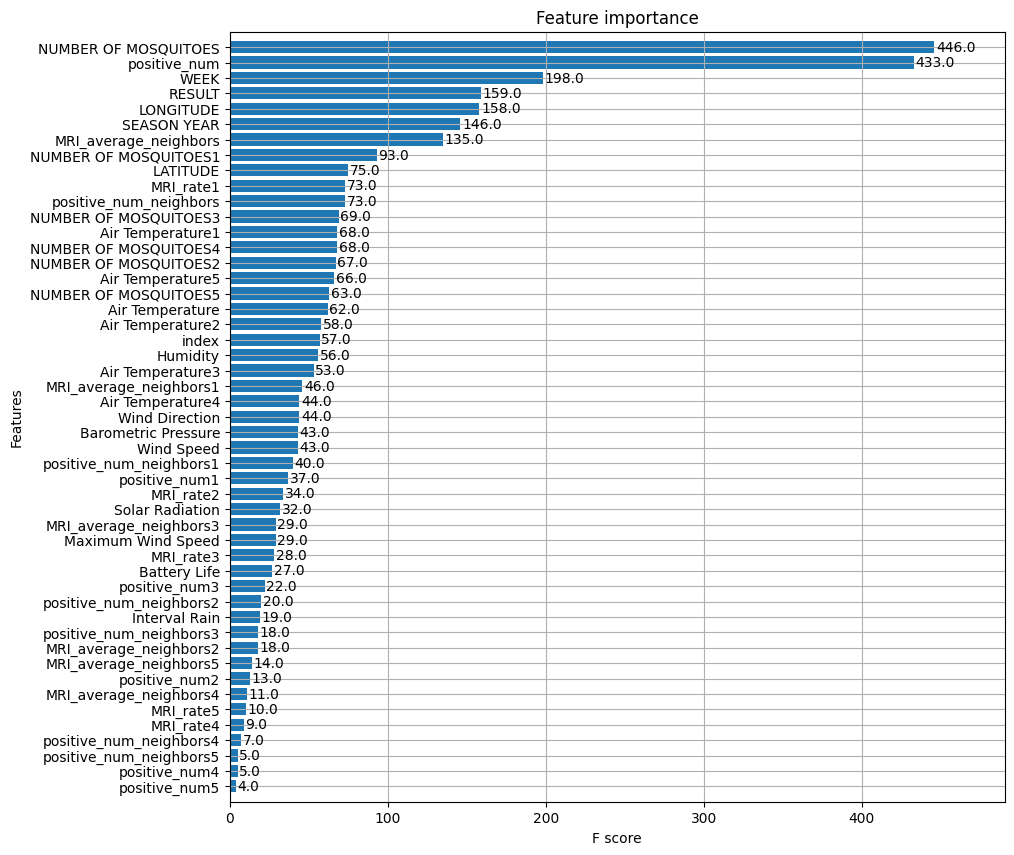

In [251]:
# Let's see the feature importance for XBG model
import xgboost as xgb
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgb_model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [252]:
scores = cross_val_score(model, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
# 0.96 accuracy -> pretty bad?
# now it is 0.88 :(( with such a high mse

0.89 accuracy with a standard deviation of 0.08


##2.8 RNN AND LSTM


### 2.8.1 Value Scaling + Splitting

In [253]:
#Scaling to speed up the learning process (commented out for now since it doesn't take too long to learn right now)
from sklearn.preprocessing import MinMaxScaler
final_res = final_res.sort_values(by=['SEASON YEAR','WEEK']) #order by Date so our data is continous
X = final_res.drop(['TRAP','MRI_rate','BLOCK_y','Station Name','Date','MRI_next_week','MRI_next2_week'],axis=1)
y = final_res['MRI_rate']
X_next = X
y_next = final_res['MRI_next_week']
X_next2 = X
y_next2 = final_res['MRI_next2_week']


X, X_test, y, y_test = train_test_split(X,y,test_size=0.2,train_size=0.8, shuffle=False)
X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size = 0.25,train_size =0.75, shuffle=False)

X, X_test1, y, y_test1 = train_test_split(X_next,y_next,test_size=0.2,train_size=0.8, shuffle=False)
X_train1, X_cv1, y_train1, y_cv1 = train_test_split(X,y,test_size = 0.25,train_size =0.75,shuffle=False)

X, X_test2, y, y_test2 = train_test_split(X_next2,y_next2,test_size=0.2,train_size=0.8,shuffle=False)
X_train2, X_cv2, y_train2, y_cv2 = train_test_split(X,y,test_size = 0.25,train_size =0.75,shuffle=False)


scaler = MinMaxScaler()
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_cv)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_arr = scaler.transform(y_cv.values.reshape(-1, 1))
y_test_arr = scaler.transform(y_test.values.reshape(-1, 1))

# scaling data for predicting next week
scaler = MinMaxScaler()
X_train_arr1 = scaler.fit_transform(X_train1)
X_val_arr1 = scaler.transform(X_cv1)
X_test_arr1 = scaler.transform(X_test1)

y_train_arr1 = scaler.fit_transform(y_train1.values.reshape(-1, 1))
y_val_arr1 = scaler.transform(y_cv1.values.reshape(-1, 1))
y_test_arr1 = scaler.transform(y_test1.values.reshape(-1, 1))

#scaling data for predicting next 2 week
X_train_arr2 = scaler.fit_transform(X_train2)
X_val_arr2 = scaler.transform(X_cv2)
X_test_arr2 = scaler.transform(X_test2)

y_train_arr2 = scaler.fit_transform(y_train2.values.reshape(-1, 1))
y_val_arr2 = scaler.transform(y_cv2.values.reshape(-1, 1))
y_test_arr2 = scaler.transform(y_test2.values.reshape(-1, 1))


In [254]:
# preparing data for neural network training
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

# for predicting next week
train_features = torch.Tensor(X_train_arr1)
train_targets = torch.Tensor(y_train_arr1)
val_features = torch.Tensor(X_val_arr1)
val_targets = torch.Tensor(y_val_arr1)
test_feature= torch.Tensor(X_test_arr1)
test_targets = torch.Tensor(y_test_arr1)

train= TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader1 = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader1 = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader1 = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one1 = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

# for predicting of next 2 weeks
train_features = torch.Tensor(X_train_arr2)
train_targets = torch.Tensor(y_train_arr2)
val_features = torch.Tensor(X_val_arr2)
val_targets = torch.Tensor(y_val_arr2)
test_feature= torch.Tensor(X_test_arr2)
test_targets = torch.Tensor(y_test_arr2)

train= TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader2 = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader2 = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader2 = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one2 = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [255]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        """The __init__ method that initiates an RNN instance.

        Args:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        """
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [256]:
class LSTMModel(nn.Module):
    """LSTMModel class extends nn.Module class and works as a constructor for LSTMs.

       LSTMModel class initiates a LSTM module based on PyTorch's nn.Module class.
       It has only two methods, namely init() and forward(). While the init()
       method initiates the model with the given input parameters, the forward()
       method defines how the forward propagation needs to be calculated.
       Since PyTorch automatically defines back propagation, there is no need
       to define back propagation method.

       Attributes:
           hidden_dim (int): The number of nodes in each layer
           layer_dim (str): The number of layers in the network
           lstm (nn.LSTM): The LSTM model constructed with the input parameters.
           fc (nn.Linear): The fully connected layer to convert the final state
                           of LSTMs to our desired output shape.

    """
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        """The __init__ method that initiates a LSTM instance.

        Args:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        """
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [257]:
class GRUModel(nn.Module):
    """GRUModel class extends nn.Module class and works as a constructor for GRUs.

       GRUModel class initiates a GRU module based on PyTorch's nn.Module class.
       It has only two methods, namely init() and forward(). While the init()
       method initiates the model with the given input parameters, the forward()
       method defines how the forward propagation needs to be calculated.
       Since PyTorch automatically defines back propagation, there is no need
       to define back propagation method.

       Attributes:
           hidden_dim (int): The number of nodes in each layer
           layer_dim (str): The number of layers in the network
           gru (nn.GRU): The GRU model constructed with the input parameters.
           fc (nn.Linear): The fully connected layer to convert the final state
                           of GRUs to our desired output shape.

    """
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        """The __init__ method that initiates a GRU instance.

        Args:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        """
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out 


In [258]:
class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """
    def __init__(self, model, loss_fn, optimizer):
        """
        Args:
            model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
            loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
            optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        """
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x, y):
        """The method train_step completes one step of training.

        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        Args:
            x (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        """The method train performs the model training

        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. If early stopping is enabled, then it  checks the stopping condition
        to decide whether the training needs to halt before n_epochs steps. Finally, it saves
        the model in a designated file path.

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader that stores training data
            val_loader (torch.utils.data.DataLoader): DataLoader that stores validation data
            batch_size (int): Batch size for mini-batch training
            n_epochs (int): Number of epochs, i.e., train steps, to train
            n_features (int): Number of feature columns

        """
        #model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        #torch.save(self.model.state_dict())

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        Args:
            test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
            batch_size (int): Batch size for mini-batch training
            n_features (int): Number of feature columns

        Returns:
            list[float]: The values predicted by the model
            list[float]: The actual values in the test set.

        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values

    def plot_losses(self):
        """The method plots the calculated loss values for training and validation
        """
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [262]:
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel
  
    }
    return models.get(model.lower())(**model_params)

[1/20] Training loss: 0.0047	 Validation loss: 0.0014
[2/20] Training loss: 0.0035	 Validation loss: 0.0010
[3/20] Training loss: 0.0027	 Validation loss: 0.0005
[4/20] Training loss: 0.0023	 Validation loss: 0.0003
[5/20] Training loss: 0.0022	 Validation loss: 0.0003
[6/20] Training loss: 0.0020	 Validation loss: 0.0002
[7/20] Training loss: 0.0020	 Validation loss: 0.0002
[8/20] Training loss: 0.0019	 Validation loss: 0.0002
[9/20] Training loss: 0.0019	 Validation loss: 0.0002
[10/20] Training loss: 0.0017	 Validation loss: 0.0002


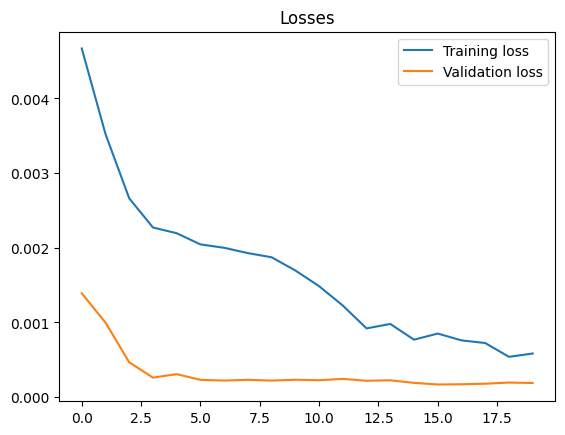

In [263]:
#training using lstm for predicting this week
import torch.optim as optim

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 20
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('lstm', model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

[1/20] Training loss: 0.0594	 Validation loss: 0.0489
[2/20] Training loss: 0.0598	 Validation loss: 0.0484
[3/20] Training loss: 0.0574	 Validation loss: 0.0465
[4/20] Training loss: 0.0512	 Validation loss: 0.0458
[5/20] Training loss: 0.0497	 Validation loss: 0.0456
[6/20] Training loss: 0.0485	 Validation loss: 0.0457
[7/20] Training loss: 0.0476	 Validation loss: 0.0457
[8/20] Training loss: 0.0471	 Validation loss: 0.0458
[9/20] Training loss: 0.0469	 Validation loss: 0.0459
[10/20] Training loss: 0.0464	 Validation loss: 0.0460


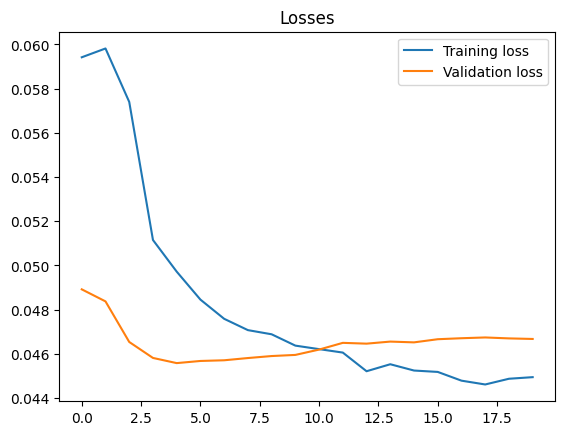

In [264]:
#training using lstm for predicting next week
import torch.optim as optim

input_dim = len(X_train1.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 20
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('lstm', model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader1, val_loader1, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions1, values1 = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

[1/20] Training loss: 0.0585	 Validation loss: 0.0405
[2/20] Training loss: 0.0579	 Validation loss: 0.0403
[3/20] Training loss: 0.0567	 Validation loss: 0.0398
[4/20] Training loss: 0.0533	 Validation loss: 0.0389
[5/20] Training loss: 0.0517	 Validation loss: 0.0389
[6/20] Training loss: 0.0510	 Validation loss: 0.0388
[7/20] Training loss: 0.0504	 Validation loss: 0.0389
[8/20] Training loss: 0.0500	 Validation loss: 0.0390
[9/20] Training loss: 0.0495	 Validation loss: 0.0390
[10/20] Training loss: 0.0492	 Validation loss: 0.0390


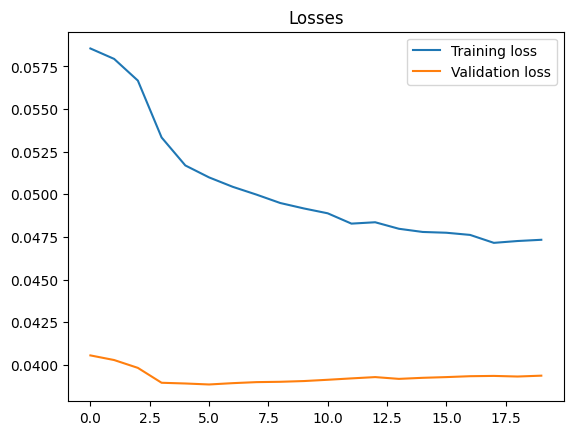

In [265]:
#training using lstm for predicting next 2 week
import torch.optim as optim

input_dim = len(X_train1.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 20
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('lstm', model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader2, val_loader2, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions2, values2 = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

[1/20] Training loss: 0.0628	 Validation loss: 0.0491
[2/20] Training loss: 0.0592	 Validation loss: 0.0483
[3/20] Training loss: 0.0553	 Validation loss: 0.0461
[4/20] Training loss: 0.0505	 Validation loss: 0.0465
[5/20] Training loss: 0.0492	 Validation loss: 0.0467
[6/20] Training loss: 0.0485	 Validation loss: 0.0467
[7/20] Training loss: 0.0476	 Validation loss: 0.0470
[8/20] Training loss: 0.0471	 Validation loss: 0.0471
[9/20] Training loss: 0.0473	 Validation loss: 0.0470
[10/20] Training loss: 0.0472	 Validation loss: 0.0468


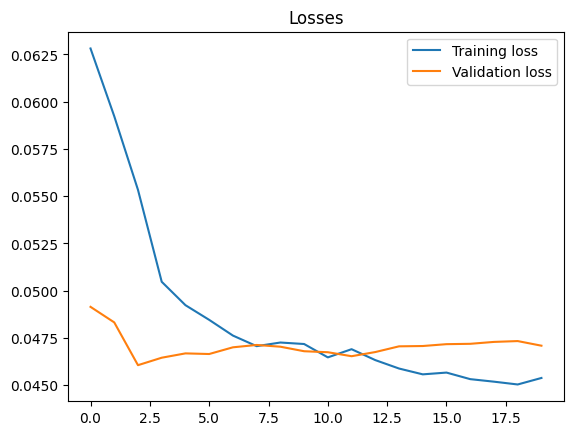

In [266]:
# training using GRU MODEL
import torch.optim as optim

input_dim = len(X_train1.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 20
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('gru', model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

device = torch.device('cpu')
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader1, val_loader1, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions1, values1 = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

In [267]:
# View prediction
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    preds[preds < 0] = 0
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, X_test, scaler)
df_result[df_result.prediction < 50] = 0
df_result[0:70]

value  prediction
1180    0.000000    0.000000
1181    0.000000    0.000000
1182    0.000000    0.000000
1183    0.000000    0.000000
1184    0.000000    0.000000
...          ...         ...
1245    0.000000    0.000000
1246   93.773445  130.228806
1247  111.234703  103.300209
1248    0.000000    0.000000
1249  143.031052  104.448456

[70 rows x 2 columns]

In [268]:
# View prediction for next week 
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    preds[preds < 0] = 0
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


df_result1 = format_predictions(predictions1, values1, X_test1, scaler)
df_result1[df_result1.prediction < 50] = 0
df_result1[0:70]

value  prediction
1180    0.000000    0.000000
1181    0.000000    0.000000
1182    0.000000    0.000000
1183    0.000000    0.000000
1184    0.000000    0.000000
...          ...         ...
1245    0.000000  185.655411
1246   93.773445  291.441681
1247  111.234703  338.144867
1248    0.000000  169.303162
1249  143.031052  281.621063

[70 rows x 2 columns]

In [269]:
# View prediction for next 2 week 
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    preds[preds < 0] = 0
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


df_result2 = format_predictions(predictions2, values2, X_test2, scaler)
df_result2[df_result2.prediction < 50] = 0
df_result2[0:70]

value  prediction
1180    0.000000    0.000000
1181    0.000000    0.000000
1182    0.000000    0.000000
1183    0.000000    0.000000
1184    0.000000    0.000000
...          ...         ...
1245    0.000000  201.233185
1246   93.773445  248.273376
1247  111.234703  382.346680
1248    0.000000  167.476654
1249  143.031052  267.144470

[70 rows x 2 columns]

In [270]:
# See evaluation metrics for this week
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    result_metrics = {'mae' : mean_absolute_error(df.value, df.prediction),
                      'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
                      'mse' : mean_squared_error(df.value, df.prediction),
                      'r2' : r2_score(df.value, df.prediction)}
    
    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Mean Squared Error:        ", result_metrics['mse'])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    return result_metrics

result_metrics = calculate_metrics(df_result)

Mean Absolute Error:        4.9831557
Mean Squared Error:         308.84534
Root Mean Squared Error:    17.57399604284872
R^2 Score:                  0.8616423295941649


In [271]:
# See evaluation metrics for next week
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

result_metrics = calculate_metrics(df_result1)

Mean Absolute Error:        24.832687
Mean Squared Error:         3499.2822
Root Mean Squared Error:    59.154731227201935
R^2 Score:                  -1.0178553956380156


In [272]:
# See evaluation metrics for next 2 week
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
result_metrics = calculate_metrics(df_result2)

Mean Absolute Error:        21.16947
Mean Squared Error:         2843.68
Root Mean Squared Error:    53.32616554413626
R^2 Score:                  -0.8820349256418334


## 2.9 Features

Briefly explain which features you used and how you created them. If you created lagged features (in space or time) then state how many lags you used and why. Explain why these features were important for improving accuracy.

 - For features selections to use with Multiple Linear Regression, Decision Trees, Random Forests and XGBoost, I used those that have strong correlation with the MRI_rate as observed in the correlation matrix/heatmap I produced in EDA.** 

 - Lagged Features: I generated lagged features up to 5 weeks ago, and the features that I used to generate past values are: MRI_rate','NUMBER OF MOSQUITOES','positive_num','Air Temperature','MRI_average_neighbors','positive_num_neighbors. The reason I chose to generate these features also because of their high correlation with MRI_rate**.

- Spatial Features: The neighboring traps might have also had an effect on the trap themselves, so we decided to use K-nearest neighbors (Ball Tree) again to match our trap with its 5 nearest neighbors. After matching, we decided to include the average MIR_rate of our 5 neighbors to our dataset. At first, we were thinking of including all 5 of them, but there are a lot of missing values + inconsistent data, so we think our best way to include the neighbors’ MIR is to take the average of them. Other neighborings factors that we considered were positive_num, num_of_mosquitoes, RESULT, air temperature conditions. 

- These features are important to improve accuracy since including the highly correlated features will help the models learn better and avoid all the noises it might get from other un-correlated features. For neural network, we didn't necessarily perform any feature engineering since it is supposed to be able to pick up on its own

## 2.10 Model choice and training


Model choice and Training Details:
- For choosing our model, we first acknowledged that this is a regression problem (predicting a continous, numeric value). The first thought that comes to mind for regression is Multiple Linear Regression. However, looking at the pairplots and other factors during our EDA, we saw that Multiple Linear regression is not an ideal choice for our model. Hence, we seek other regression models that are more complex and can be able to predict non-linear patterns. Some of the first ones that come to mind are K-nearest neighbors and decision trees. After running model, we see that these produce better result than Multiple Linear regression, however, it is still quite not the result we want to. Another approach we seek is to explore ensemble model, some of those being Random Forest and XGBoost (a very popular ensemble model that outperforms Random Forest and even Neural Network in some of the time-series cases).


- For Neural network, I chose to test it out with LSTM and GRU specifically. LSTM is an updated version of RNN, and is known to work extremely well with time-series data. Since our data are related to each other by past and future values, LSTM is deemed to be a good potential model for this. GRU is also another version of RNN, and is shown that it might works better than LSTM in some cases. For LSTM and GRU, these are the details about the customization that I implemented: `` output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 20
learning_rate = 1e-3
weight_decay = 1e-6``

- For data splitting procedure, I splitted the data into 3 parts: training, validation, and testing data, with the ratio of 60:20:20. The X-parts will be the same for predicting this week, next week, and the week after, while the y-value will change accordingly to our desirable prediction outcome (y = final_res['MRI_next_week']) if we want to predict MRI of next week

- After testing out various different models, I noticed that most of the time, the predictions for the current week will always be significantly better compares to the predictions for the next week and the week after. To save computation time + memory usage, I shorten the model selection process by only running the predictions for the current week first, pick the top models that perform in this category, then use those to predict the values for the next 2 weeks, and do the selection process again.


# Part 3. Model Comparisons

Regardless of what kind of model you built you need to compare it with some baseline approaches. Otherwise how will we know you did a good job?

We covered the following models in class 
1. Linear Regression
2. Nearest Neighbors
3. Decision Trees
4. Random Forests
5. Neural Networks

Compare your proposed model against each one of these "alternative" approaches. You don't need to compare against a model of the same type as you proposed (i.e. if you used linear regression then you don't compare against linear regression). As best a possible, these models should use all of the features that your proposed model uses.

Using the appropriate metrics we covered in class, which could include
1. Confusion matrix summaries
2. AUC/ROC 
3. Scoring rules
4. loss functions

Illustrate the advantages and disadvantages of your proposed model against the other approaches. Include plots and tables as necessary. Then explain in simple english why someone should use your proposed model instead of these alternatives. Imagine you are explaining your results to someone who doesn't know anything about machine learning.

Example plot and table ideas:
 - Plot of test loss over time averaged over trap locations for all methods
 - Plot of test loss at each trap location averaged over time for all methods
 - Table of test loss for each method broken out by the prediction lag (one, two, or three weeks in advance).

In [273]:
# model evaluation for multiple linear regression
print('Model evaluation for MLR:')
mse = mean_squared_error(y_test, predictions_mlr)
r2 = r2_score(y_test, predictions_mlr)
mae = mean_absolute_error(y_test, predictions_mlr)
# Print the mean squared error and R-squared score
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared score:", r2)

Model evaluation for MLR:
Mean Squared Error: 40049.35910667873
Mean Absolute Error: 153.89526956462507
R-squared score: 0.5332606751811053


In [274]:
print('Model evaluation for KNN:')
mse = mean_squared_error(y_test, predictions_knn)
r2 = r2_score(y_test, predictions_knn)
mae = mean_absolute_error(y_test, predictions_knn)
# Print the mean squared error and R-squared score
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared score:", r2)

Model evaluation for KNN:
Mean Squared Error: 91436.9749724165
Mean Absolute Error: 139.6882391621302
R-squared score: -0.06561585288866434


In [275]:
print ('Model Evaluation for decision tree: ')
mse = mean_squared_error(y_test, prediction_dt)
r2 = r2_score(y_test, prediction_dt)
mae = mean_absolute_error(y_test, prediction_dt)
# Print the mean squared error and R-squared score
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared score:", r2)

Model Evaluation for decision tree: 
Mean Squared Error: 205851.63575251587
Mean Absolute Error: 51.94270363006599
R-squared score: -1.399016004927078


In [276]:
print('Model Evaluation for Random Forest')
y_pred_rf = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
# Print the mean squared error and R-squared score
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared score:", r2)

Model Evaluation for Random Forest
Mean Squared Error: 59510.30739373147
Mean Absolute Error: 35.015505167969266
R-squared score: 0.3064607945727865


In [277]:
# model evaluation for xgboost
print('Model Evaluation for XGBOOST')
mse = mean_squared_error(y_test, predictions_xgb)
r2 = r2_score(y_test, predictions_xgb)
mae = mean_absolute_error(y_test, predictions_xgb)
# Print the mean squared error and R-squared score
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared score:", r2)

Model Evaluation for XGBOOST
Mean Squared Error: 1281.8207595152592
Mean Absolute Error: 9.378488527034875
R-squared score: 0.9850615298426779


In [ ]:
# Let's see the feature importance for XBG model
import xgboost as xgb
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgb_model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [278]:
# model evaluation metrics for LSTM:
print('Model evaluation for LSTM:')
result_metrics = calculate_metrics(df_result)

Model evaluation for LSTM:
Mean Absolute Error:        4.9831557
Mean Squared Error:         308.84534
Root Mean Squared Error:    17.57399604284872
R^2 Score:                  0.8616423295941649


[1/20] Training loss: 0.0050	 Validation loss: 0.0014
[2/20] Training loss: 0.0038	 Validation loss: 0.0012
[3/20] Training loss: 0.0030	 Validation loss: 0.0004
[4/20] Training loss: 0.0023	 Validation loss: 0.0003
[5/20] Training loss: 0.0022	 Validation loss: 0.0003
[6/20] Training loss: 0.0021	 Validation loss: 0.0003
[7/20] Training loss: 0.0020	 Validation loss: 0.0003
[8/20] Training loss: 0.0019	 Validation loss: 0.0003
[9/20] Training loss: 0.0018	 Validation loss: 0.0002
[10/20] Training loss: 0.0016	 Validation loss: 0.0002


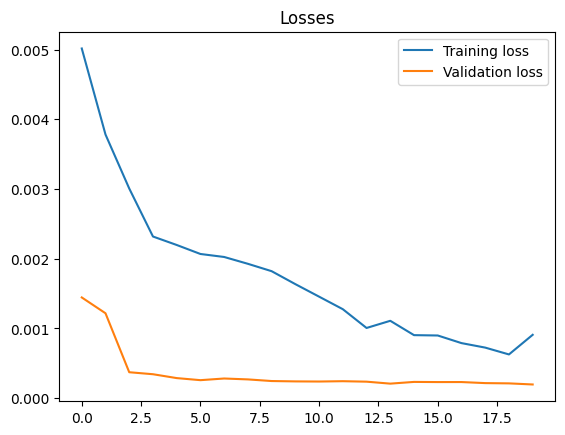

In [279]:
# Example of training loss procedure + plot for LSTM to predict current week (you can scroll up to the model part to see the loss plots for every model)
model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('lstm', model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

### 3.1 Metrics and evaluation

Briefly explain what metrics you will use to evaluate your procedure and why.
- The metrics that I will use mostly to evaluate my metrics are Mean Squared Error, Mean Absolute Error and R^2 square value. 

- We do acknowledge that our data is non-linear. Therefore, R^2 value and MSE might be highly inaccurate because of this. Another metrics that we think of for future implementation are cross-validation and chi-squared goodness of fit test. We will put down the code for those implementations for record.

In [280]:
print("Metrics Evaluaton from XGBoost for next week's prediction")
mse = mean_squared_error(y_test1, y_pred_xgb_next)
r2 = r2_score(y_test1, y_pred_xgb_next)
mae = mean_absolute_error(y_test1, y_pred_xgb_next)
# Print the mean squared error and R-squared score
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared score:", r2)

Metrics Evaluaton from XGBoost for next week's prediction
Mean Squared Error: 83071.45883200964
Mean Absolute Error: 168.8088804261453
R-squared score: -0.11491206091204398


In [ ]:
# model evaluation for xgboost (example code for reference if using cross-validation and chi-squared test)
print('Model Evaluation for XGBOOST')
scores = cross_val_score(xgb_model, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
predictions_xgb = np.array(y_pred_xgb)
predictions_xgb = scaler.fit_transform(predictions_xgb.reshape(-1,1))
print("The chi-squared test statistis is",chisquare(y_test_scaled,f_exp=predictions_xgb))

In [281]:
# See evaluation metrics for next week (using the GRU model)
print("Metrics Evaluaton from LSTM for next week's prediction")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
result_metrics = calculate_metrics(df_result1)

Metrics Evaluaton from LSTM for next week's prediction
Mean Absolute Error:        24.832687
Mean Squared Error:         3499.2822
Root Mean Squared Error:    59.154731227201935
R^2 Score:                  -1.0178553956380156


In [282]:
# See evaluation metrics for next 2 week
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
result_metrics = calculate_metrics(df_result2)

Mean Absolute Error:        21.16947
Mean Squared Error:         2843.68
Root Mean Squared Error:    53.32616554413626
R^2 Score:                  -0.8820349256418334


- Upon evaluation for the predictions of next week and the next 2 weeks, we see that the LSTM outperforms the XGboost in terms of MSE and MAE score. Because of this reason, we will choose LSTM as our final choice. 
- What interesting to notice is that although the MSE and MAE score are looking good on the LSTM, the R-squared values are actually negative (as expected since our data is non-linear), which might indicates that our model is performing not as good as just the mean values. In fact, for most of the models that we explored so far, most of these yield negative R-squared score for predicting future values of MRI, while the R-squared score for predicting the current week typically looks good in genral. This might yield some questions back to how we process the data for future predictions. Upon doing data engineering for the lagged features data part, we had to drop a lot of columns due to the fact that our data does not have a lot of consistent values, a lot of weeks were missing, either because of the fact that they don't have weather data values, or or they don't have consistent timing value week by week in general. This makes predicting the value for current week good (because we have enough data for that week specifically, but not necessarily have any future values for training). To further improve the accuracy and for future outlook, we can try to use other evaluation methods like cross validation and chi-squared goodness of fit test for to better allocate the accuracy or the fit of our model.

# Part 4. Visualizations

Assuming your model is good enough to deploy, lets see in action!

Apply your model to the held out data and plot the results. Unfortunately for you, you have spatiotemporal data which is a bit hard to visualize so lets create the following plots

1. __Temporal :__ Plot the predicted and actual weekly MIR aggregated across all trap locations to get a sense of your models accuracy over time. Is there any discernable pattern in the performance of your model over time? Also which weeks are predicted to be ``hot'', i.e. have high MIR. 
2. __Spatial :__ Now pick a few time points with high predicted MIR and plot the trap specific predicted MIR at each trap location overlaid on a map of Chicago. This plot should clearly show 
  1. The location of each trap (use latitude and longitude coordinates)
  2. The MIR value (color code the points and include a color scale)

  Can you identify any hot spots (areas with higher than average MIR)?
3. __Custom :__ You know your model much better than me. Create one final plot that shows how great / useful your model is or illustrates some aspect of the model not covered in the above plots.

### 4.1 Temporal behavior

Display the temporal plot here and briefly explain what it shows. Identify any important seeming patterns or trends.

In [284]:
%cd /content/drive/MyDrive/CSCE_421_FINAL_PROJECT/Data
df = pd.read_csv('wnv_weather.csv')

/content/drive/MyDrive/CSCE_421_FINAL_PROJECT/Data


In [285]:
import plotly.express as px

##average MRI rate for each trap by year
avg_data = df.groupby(['SEASON YEAR', 'TRAP'])['MRI_rate'].mean().reset_index()
custom_colors = px.colors.qualitative.Safe
fig = px.box(avg_data, x="SEASON YEAR", y="MRI_rate", color="TRAP", points="all", color_discrete_sequence=custom_colors)

In [286]:
fig.update_layout(title="Distribution of MRI_rate Over Season Year (Grouped by TRAP)", xaxis_title="Year", yaxis_title="MRI_rate")
fig.show()
# From the plot, we can see that the distribution of the MRI_rate has a lot of values that are zeros. We can see here that there is an outlier of positivity over 500 from T223

In [287]:
##now the same for average air temperature for each trap:
avg_data = df.groupby(['SEASON YEAR', 'TRAP'])['Air Temperature'].mean().reset_index()
custom_colors = px.colors.qualitative.Safe
fig = px.box(avg_data, x="SEASON YEAR", y="Air Temperature", color="TRAP", points="all",color_discrete_sequence=custom_colors)

In [288]:
fig.update_layout(title="Distribution of Air Temperature Over Season Year (Grouped by TRAP)", xaxis_title="Year", yaxis_title="MRI_rate")
fig.show()
# We can see that the air temperature stays pretty consistent over time during the summer. The rang is around 20-25

In [289]:
##now for humidity:
avg_data = df.groupby(['SEASON YEAR', 'TRAP'])['Humidity'].mean().reset_index()
#avg_data = avg_data[avg_data['MRI_rate'] > 0]
custom_colors = px.colors.qualitative.Safe
fig = px.box(avg_data, x="SEASON YEAR", y="Humidity", color="TRAP", points="all", color_discrete_sequence=custom_colors)

In [290]:
fig.update_layout(title="Distribution of Average Humidity Over Season Year (Grouped by TRAP)", xaxis_title="Year", yaxis_title="MRI_rate")
fig.show()
# For humidity, we can see a more spreaded out distribution

In [301]:
##now let's look at MIR_rate each week for each trap in 2015
grouped = df.groupby(['WEEK', 'TRAP', "SEASON YEAR"])['MRI_rate'].mean().reset_index()
grouped = grouped[grouped["SEASON YEAR"] == 2015]

In [292]:
fig = px.line(grouped, x="WEEK", y="MRI_rate", color="TRAP")
fig.update_layout(title="Average MRI_rate Over Week (Grouped by TRAP) in 2015", xaxis_title="Week", yaxis_title="MRI_rate")
fig.show()
# Looking at average MRI rate over the week (in 2015), we can see that the values stay fairly consistent, and there was a peak at around week 32-34.

In [293]:
##the same thing for 2022
grouped = df.groupby(['WEEK', 'TRAP', "SEASON YEAR"])['MRI_rate'].mean().reset_index()
grouped = grouped[grouped["SEASON YEAR"] == 2022]

In [294]:
fig = px.line(grouped, x="WEEK", y="MRI_rate", color="TRAP")
fig.update_layout(title="Average MRI_rate Over Week (Grouped by TRAP) in 2022", xaxis_title="Week", yaxis_title="MRI_rate")
fig.show()
# In here, we can see that the average MRI rate has consistent peaks at around the range 800-1000

In [295]:
##and now the same thing for 2015 but this time looking at positive_num
##average num of positive mosquitoes in 2015
grouped = df.groupby(['WEEK', 'TRAP', "SEASON YEAR"])['positive_num'].mean().reset_index()
grouped = grouped[grouped["SEASON YEAR"] == 2015]

In [296]:
fig = px.line(grouped, x="WEEK", y="positive_num", color="TRAP")
fig.update_layout(title="Average ## of Mosquitoes Positive for West Nile Virus Over Week (Grouped by TRAP) in 2015", xaxis_title="Week", yaxis_title="MRI_rate")
fig.show()

In [297]:
##now in 2022
grouped = df.groupby(['WEEK', 'TRAP', "SEASON YEAR"])['positive_num'].mean().reset_index()
grouped = grouped[grouped["SEASON YEAR"] == 2022]

In [298]:
fig = px.line(grouped, x="WEEK", y="positive_num", color="TRAP")
fig.update_layout(title="Average ## of Mosquitoes Positive for West Nile Virus Over Week (Grouped by TRAP) in 2022", xaxis_title="Week", yaxis_title="MRI_rate")
fig.show()

### 4.2 Spatial behavior

Display the spatial plot here and briefly explain what it shows. Identify any important seeming patterns or trends.


In [304]:
df = pd.read_csv('final_data.csv')

In [305]:
## we are going to plot the average air temperature for each location over all the time we are given
dfg = df.groupby(['LATITUDE', 'LONGITUDE'])['Air Temperature'].mean().reset_index()

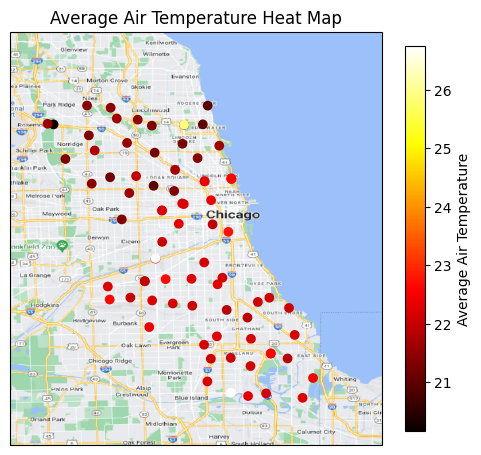

In [306]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

import cartopy.io.img_tiles as cimgt
stamen_terrain = cimgt.GoogleTiles()

fig = plt.figure(figsize = (6, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-87.9, -87.45, 41.6, 42.1], crs=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 11)
ax.set_aspect('auto')

sc = ax.scatter(dfg['LONGITUDE'], dfg['LATITUDE'], c=dfg['Air Temperature'], cmap='hot', transform=ccrs.PlateCarree())
plt.colorbar(sc, label='Average Air Temperature', shrink=0.5)

ax.coastlines()  
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average Air Temperature Heat Map')
##plt.show()

# save figure so we can load it later
plt.savefig('trap_map.png', bbox_inches = 'tight')
plt.show()

In [307]:
##it clearly gets warmer the further south that you go, except for one outlier (the yellow dot)

In [308]:
##now we'll do the same for MIR_rate
dfg = df.groupby(['LATITUDE', 'LONGITUDE'])['MRI_rate'].mean().reset_index()

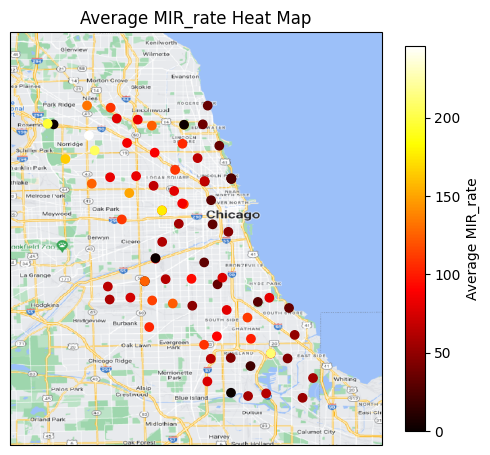

In [309]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

import cartopy.io.img_tiles as cimgt
stamen_terrain = cimgt.GoogleTiles()

fig = plt.figure(figsize = (6, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-87.9, -87.45, 41.6, 42.1], crs=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 11)
ax.set_aspect('auto')

sc = ax.scatter(dfg['LONGITUDE'], dfg['LATITUDE'], c=dfg['MRI_rate'], cmap='hot', transform=ccrs.PlateCarree())
plt.colorbar(sc, label='Average MIR_rate', shrink=0.5)

ax.coastlines() 
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average MIR_rate Heat Map')
##plt.show()

# save figure so we can load it later
plt.savefig('trap_map.png', bbox_inches = 'tight')
plt.show()

In [310]:
##it seems like the further you get from the coast, the higher your MIR_rate is aka. the further west you get the higher your average MIR_rate will be

In [311]:
##doing the same thing for Humidity:
dfg = df.groupby(['LATITUDE', 'LONGITUDE'])['Humidity'].mean().reset_index()

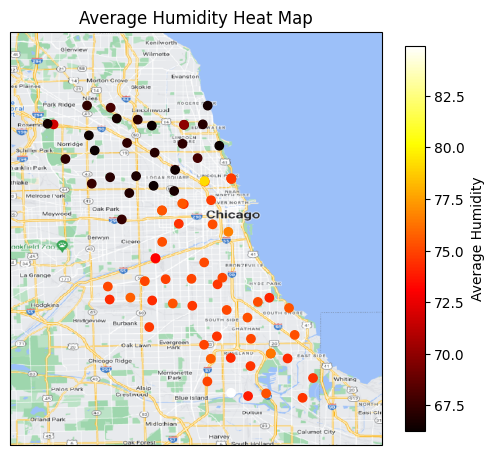

In [312]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

import cartopy.io.img_tiles as cimgt
stamen_terrain = cimgt.GoogleTiles()

fig = plt.figure(figsize = (6, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-87.9, -87.45, 41.6, 42.1], crs=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 11)
ax.set_aspect('auto')

sc = ax.scatter(dfg['LONGITUDE'], dfg['LATITUDE'], c=dfg['Humidity'], cmap='hot', transform=ccrs.PlateCarree())
plt.colorbar(sc, label='Average Humidity', shrink=0.5)

ax.coastlines()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average Humidity Heat Map')
##plt.show()

# save figure so we can load it later
plt.savefig('trap_map.png', bbox_inches = 'tight')
plt.show()